In [98]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [99]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [100]:
import os
import pandas as pd 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        globals()[filename.split('.')[0]] = pd.read_csv(dirname+'/'+filename)
        
        print(filename)

customeraccount.csv
sample_submission.csv
transaction_header.csv
genel_kategoriler.csv
customer.csv
train.csv
test.csv
product_groups.csv
transaction_sale.csv


In [124]:
import numpy as np 
import torch
import optuna
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold, KFold,train_test_split
import datetime
from datetime import date
from collections import Counter
from torch.utils.data import DataLoader,TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,f1_score,mean_squared_error,precision_score,recall_score
from itertools import combinations
from sklearn.cluster import KMeans
from imblearn.pipeline import Pipeline 
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor


pd.options.display.max_rows=250
pd.options.display.max_columns=250
pd.options.display.max_colwidth=25
cm = sns.light_palette("red", as_cmap=True)

def null_rate(df):
    return (df.isnull().sum()/df.shape[0]).to_frame().rename(columns={0:'null_rate'}).sort_values('null_rate',ascending=False).style.background_gradient(cmap=cm)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook
tqdm.pandas(desc="my bar!")



import warnings
warnings.filterwarnings('ignore')

def calculate_optimum_threshold(y_true, y_pred_labels):
    max_thresh = 0.3
    max_score = 0
    for thresh in range(30, 60, 2):
        thresh = thresh / 100
        y_pred = (y_pred_labels > thresh).astype('int')
        score = f1_score(y_true, y_pred)
        if score >= max_score:
            max_score = score
            max_thresh = thresh
        if y_pred.sum()/y_pred.shape[0] < 0.005:
            continue
    print(f"Optimum threshold: {max_thresh}, Score: {max_score}")
    return max_thresh, max_score


def classification_scores(y_true, y_pred, threshold=0.5):

    """
    Calculate binary classification metrics on predicted probabilities and labels
    Parameters
    ----------
    y_true (numpy.ndarray of shape (n_samples)): Ground truth labels
    y_pred (numpy.ndarray of shape (n_samples)): Predicted probabilities
    threshold (float): Rounding threshold
    Returns
    -------
    scores (dict): Dictionary of calculated scores
    """

    y_pred_labels = round_probabilities(y_pred, threshold=threshold)
    scores = {
         'accuracy': accuracy_score(y_true, y_pred_labels),
         'roc_auc': roc_auc_score(y_true, y_pred),
         'precision': precision_score(y_true, y_pred_labels),
         'recall': recall_score(y_true, y_pred_labels),
         'f1': f1_score(y_true, y_pred_labels),
          'pos_rate': f"{y_pred_labels.sum()}/{y_pred_labels.shape[0]}"
    }

    return scores

def round_probabilities(probabilities, threshold):

    """
    Round probabilities to labels based on the given threshold
    Parameters
    ----------
    probabilities (np.ndarray of shape (n_samples)): Predicted probabilities
    threshold (float): Rounding threshold
    Returns
    -------
    labels (numpy.ndarray of shape (n_samples)): Labels
    """

    labels = np.zeros_like(probabilities, dtype=np.uint8)
    labels[probabilities >= threshold] = 1

    return labels

# Data Preview

### 1-customerAccount

In [102]:
customeraccount=customeraccount.astype({'individualnumber':'object','cardnumber':'object'})
customeraccount.info()
customeraccount.groupby('individualnumber')['cardnumber'].count().to_frame().sort_values('cardnumber',ascending=False)[:50].style.background_gradient(cmap=cm)
print(f'customeraccount null rate.')
null_rate(customeraccount)
print(f' ')
customeraccount.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35159 entries, 0 to 35158
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   individualnumber  35159 non-null  object
 1   cardnumber        35159 non-null  object
dtypes: object(2)
memory usage: 549.5+ KB


,cardnumber
individualnumber,
96035559,49
13936527,25
98338349,21
7923458,17
10817264,17
92455160,16
92472145,16
89086894,15
42273372,15


customeraccount null rate.


,null_rate
individualnumber,0.000000
cardnumber,0.000000


,individualnumber,cardnumber
count,35159,35159
unique,28593,35159
top,96035559,7287134635560315
freq,49,1


### 2-customer

In [103]:
customer=customer.astype({'individualnumber':'object','city_code':'object'})
customer.info()
print(f'\n\n')
null_rate(customer)
print(f'\n\n')
customer.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28593 entries, 0 to 28592
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   individualnumber  28593 non-null  object 
 1   gender            28588 non-null  object 
 2   city_code         21886 non-null  object 
 3   dateofbirth       28578 non-null  float64
dtypes: float64(1), object(3)
memory usage: 893.7+ KB





,null_rate
city_code,0.234568
dateofbirth,0.000525
gender,0.000175
individualnumber,0.000000


,individualnumber,gender,city_code,dateofbirth
count,28593.0,28588,21886.0,28578.000000
unique,28593.0,2,82.0,NaN
top,94212124.0,E,34.0,NaN
freq,1.0,15192,4600.0,NaN
mean,NaN,NaN,NaN,1979.989013
std,NaN,NaN,NaN,13.892713
min,NaN,NaN,NaN,1920.000000
25%,NaN,NaN,NaN,1971.000000
50%,NaN,NaN,NaN,1982.000000
75%,NaN,NaN,NaN,1991.000000


### 3-train

In [104]:
train=train.astype({'individualnumber':'object','category_number':'object','response':'float'})
train.info()
null_rate(train)
print(f'\n\n')
customeraccount.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13115 entries, 0 to 13114
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   individualnumber  13115 non-null  object 
 1   category_number   13115 non-null  object 
 2   hakkedis_amt      13115 non-null  float64
 3   odul_amt          13115 non-null  float64
 4   response          13115 non-null  float64
dtypes: float64(3), object(2)
memory usage: 512.4+ KB


,null_rate
individualnumber,0.000000
category_number,0.000000
hakkedis_amt,0.000000
odul_amt,0.000000
response,0.000000


,individualnumber,cardnumber
count,35159,35159
unique,28593,35159
top,96035559,7287134635560315
freq,49,1


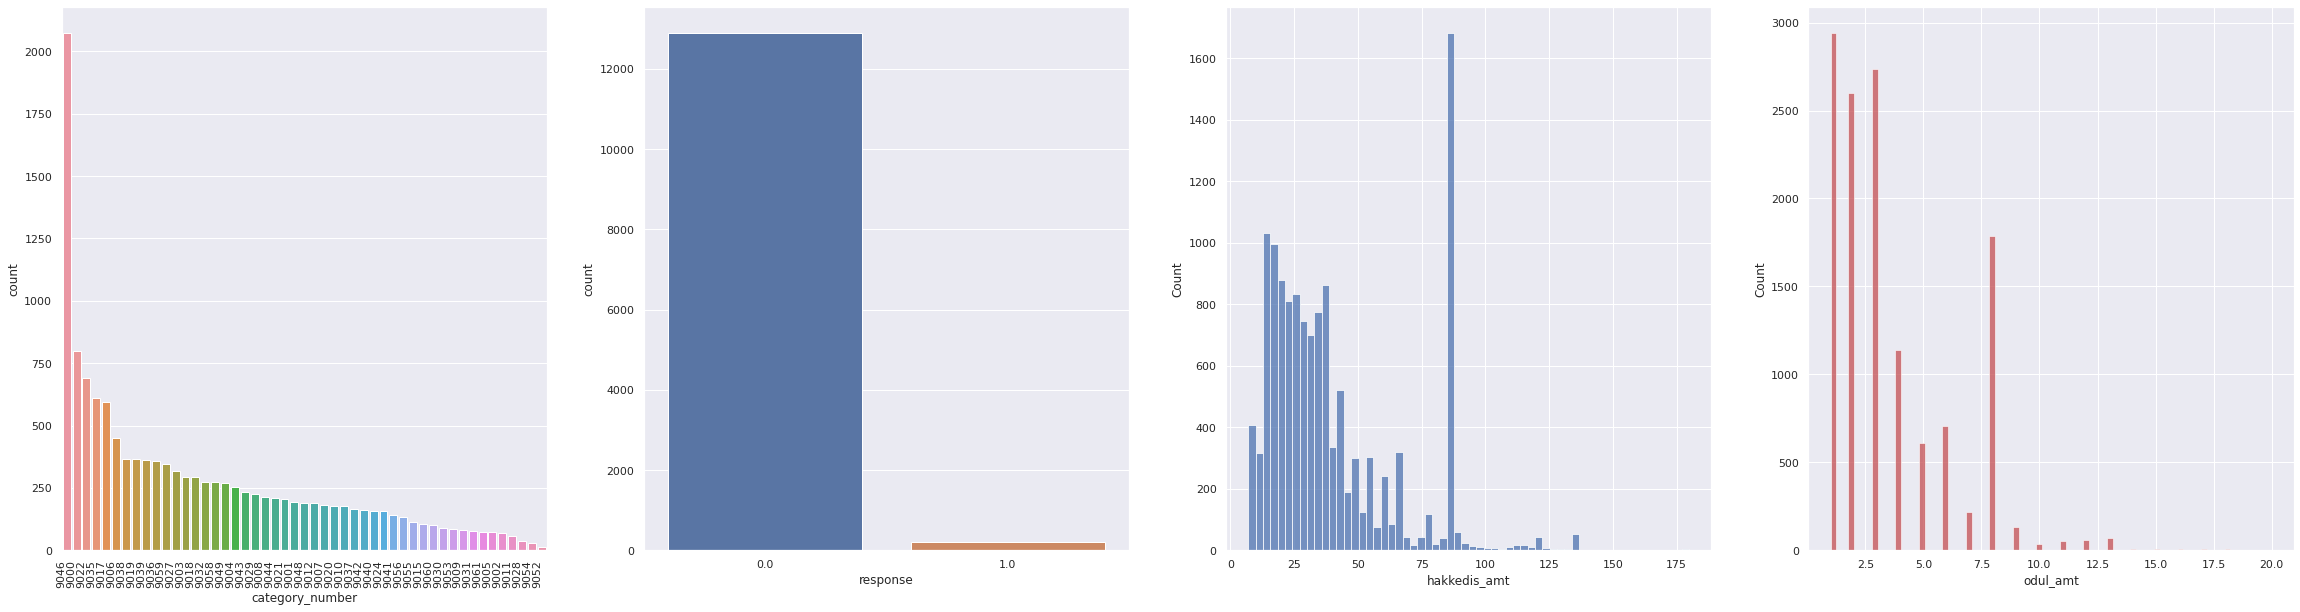

In [105]:
f,ax=plt.subplots(1,4,figsize=[40,10])
sns.countplot(train.category_number,order=train.category_number.value_counts().index,ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90,horizontalalignment='right');
sns.countplot(train.response,ax=ax[1]);
sns.histplot(train.hakkedis_amt,ax=ax[2]);
sns.histplot(train.odul_amt,ax=ax[3],color='r');

### 3-test

In [106]:
test=test.astype({'individualnumber':'object','category_number':'object'})
test.info()
print(f'\n\n')
null_rate(test)
print(f'\n\n')
test.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13236 entries, 0 to 13235
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   individualnumber  13236 non-null  object 
 1   category_number   13236 non-null  object 
 2   hakkedis_amt      13236 non-null  float64
 3   odul_amt          13236 non-null  float64
dtypes: float64(2), object(2)
memory usage: 413.8+ KB





,null_rate
individualnumber,0.000000
category_number,0.000000
hakkedis_amt,0.000000
odul_amt,0.000000


,individualnumber,category_number,hakkedis_amt,odul_amt
count,13236.0,13236.0,13236.000000,13236.000000
unique,13236.0,49.0,NaN,NaN
top,95812936.0,9046.0,NaN,NaN
freq,1.0,2078.0,NaN,NaN
mean,NaN,NaN,40.258008,3.701647
std,NaN,NaN,25.616329,2.643206
min,NaN,NaN,7.000000,1.000000
25%,NaN,NaN,21.000000,2.000000
50%,NaN,NaN,32.000000,3.000000
75%,NaN,NaN,55.000000,5.000000


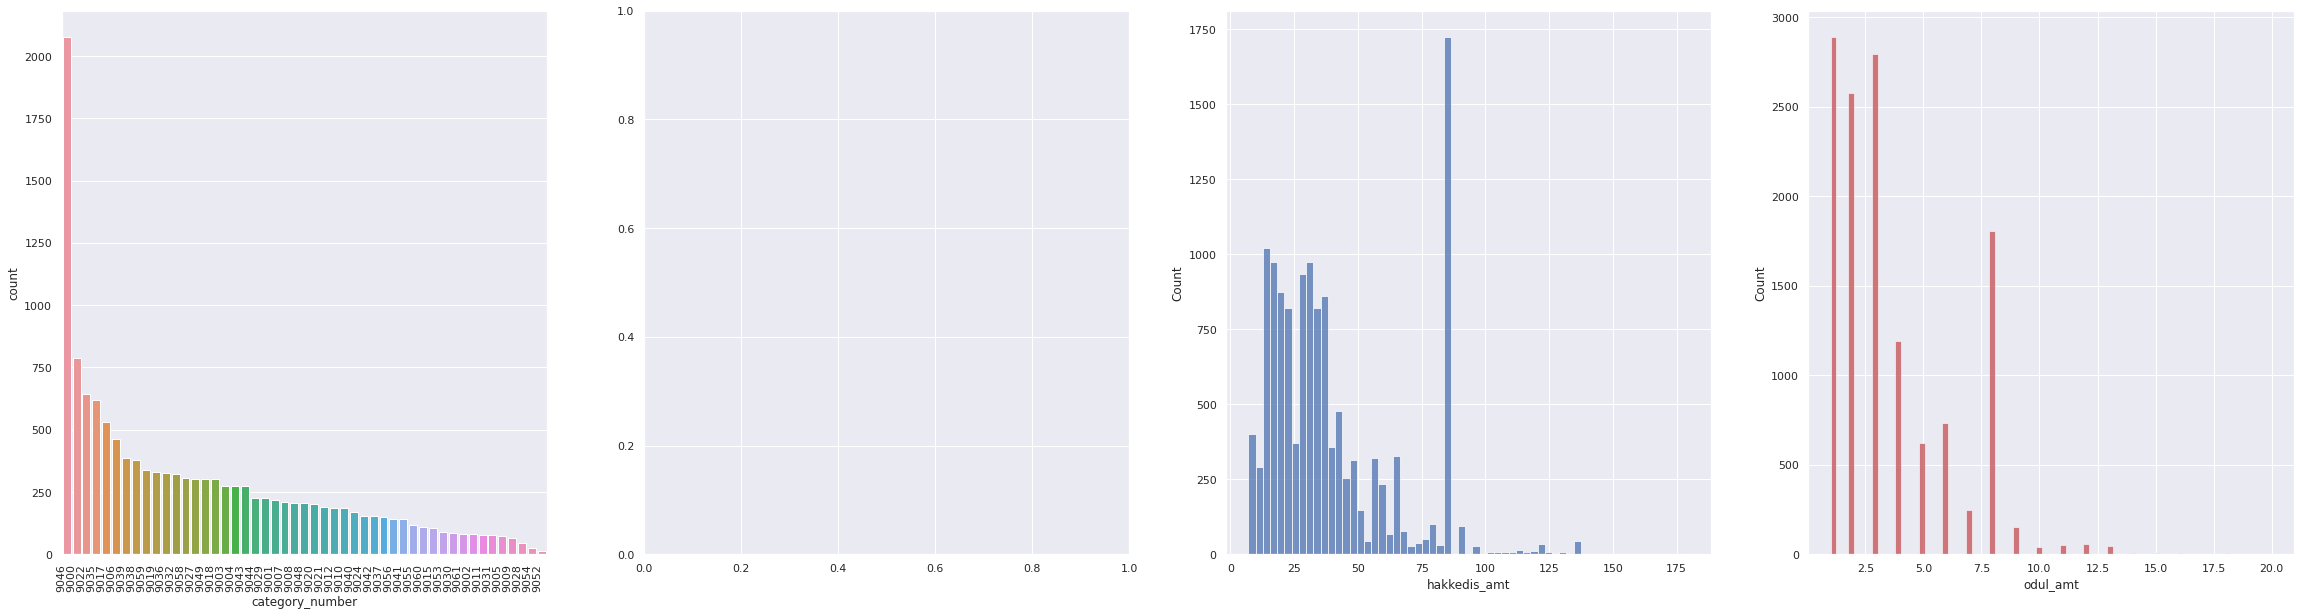

In [107]:
sns.set(context="paper", font="monospace");
sns.set(rc={'figure.figsize':(11.7,8.27)});
f,ax=plt.subplots(1,4,figsize=[40,10]);
sns.countplot(test.category_number,order=test.category_number.value_counts().index,ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90,horizontalalignment='right');
sns.histplot(test.hakkedis_amt,ax=ax[2]);
sns.histplot(test.odul_amt,ax=ax[3],color='r');

### 4-product_groups

In [108]:
product_groups=product_groups.astype({'category_number':'object','category_level_1':'object','category_level_2':'object','category_level_3':'object','category_level_4':'object'})
product_groups.info()
print(f'\n\n')
null_rate(product_groups)
print(f'\n\n')
product_groups.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3913 entries, 0 to 3912
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   category_number   3913 non-null   object
 1   category_level_1  3913 non-null   object
 2   category_level_2  3913 non-null   object
 3   category_level_3  3913 non-null   object
 4   category_level_4  3913 non-null   object
dtypes: object(5)
memory usage: 153.0+ KB





,null_rate
category_number,0.000000
category_level_1,0.000000
category_level_2,0.000000
category_level_3,0.000000
category_level_4,0.000000


,category_number,category_level_1,category_level_2,category_level_3,category_level_4
count,3913,3913,3913,3913,3913
unique,50,56,41,40,96
top,9035,300,10,10,10
freq,654,521,535,974,839


### 5-transaction_sale

In [109]:
transaction_sale=transaction_sale.astype({'basketid':'object','category_level_1':'object','category_level_2':'object','category_level_3':'object','category_level_4':'object'})
print(f'\n\n')
transaction_sale.info()
print(f'\n\n')
null_rate(transaction_sale)
print(f'\n\n')
transaction_sale.describe(include='all')




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6537881 entries, 0 to 6537880
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   basketid          object 
 1   category_level_1  object 
 2   category_level_2  object 
 3   category_level_3  object 
 4   category_level_4  object 
 5   amount            float64
 6   quantity          float64
 7   discount_type_1   float64
 8   discount_type_2   float64
 9   discount_type_3   float64
dtypes: float64(5), object(5)
memory usage: 498.8+ MB





,null_rate
discount_type_1,0.711067
discount_type_2,0.000020
discount_type_3,0.000020
basketid,0.000000
category_level_1,0.000000
category_level_2,0.000000
category_level_3,0.000000
category_level_4,0.000000
amount,0.000000
quantity,0.000000


,basketid,category_level_1,category_level_2,category_level_3,category_level_4,amount,quantity,discount_type_1,discount_type_2,discount_type_3
count,6.537881e+06,6537881.0,6537881.0,6537881.0,6537881.0,6.537881e+06,6.537881e+06,1.889008e+06,6.537751e+06,6.537753e+06
unique,1.124327e+06,70.0,40.0,40.0,85.0,NaN,NaN,NaN,NaN,NaN
top,2.105051e+16,130.0,10.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN
freq,1.650000e+02,872712.0,1376177.0,2561787.0,2220686.0,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.678373e+01,1.369372e+00,2.143040e+00,5.479906e-01,1.031550e+00
std,NaN,NaN,NaN,NaN,NaN,4.810842e+01,1.639792e+00,5.657074e+00,4.138239e+00,6.440188e+00
min,NaN,NaN,NaN,NaN,NaN,-8.150400e+03,-9.600000e+01,-5.220884e-04,-1.869100e+02,-2.400000e+02
25%,NaN,NaN,NaN,NaN,NaN,4.750000e+00,1.000000e+00,2.559020e-01,0.000000e+00,0.000000e+00
50%,NaN,NaN,NaN,NaN,NaN,9.280000e+00,1.000000e+00,7.225458e-01,0.000000e+00,0.000000e+00
75%,NaN,NaN,NaN,NaN,NaN,1.883000e+01,1.012000e+00,1.993273e+00,0.000000e+00,0.000000e+00


### 6-transaction_header

In [110]:
transaction_header=transaction_header.astype({'date_of_transaction':'datetime64','cardnumber':'object','basketid':'object','is_sanal':'object'})
transaction_header.info()
print(f'\n\n')
null_rate(transaction_header)
print(f'\n\n')
transaction_header.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124673 entries, 0 to 1124672
Data columns (total 4 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_of_transaction  1124673 non-null  datetime64[ns]
 1   cardnumber           1124673 non-null  object        
 2   basketid             1124673 non-null  object        
 3   is_sanal             1124673 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 34.3+ MB





,null_rate
date_of_transaction,0.000000
cardnumber,0.000000
basketid,0.000000
is_sanal,0.000000


,date_of_transaction,cardnumber,basketid,is_sanal
count,1124673,1.124673e+06,1.124673e+06,1124673.0
unique,366,3.031900e+04,1.124673e+06,2.0
top,2020-12-31 00:00:00,9.887855e+15,2.012016e+16,0.0
freq,5032,1.239000e+03,1.000000e+00,1024395.0
first,2020-12-01 00:00:00,NaN,NaN,NaN
last,2021-12-01 00:00:00,NaN,NaN,NaN


### genel_kategoriler

In [111]:
genel_kategoriler=genel_kategoriler.astype({'category_number':'object'})
genel_kategoriler.info()
print(f'\n\n')
null_rate(genel_kategoriler)
print(f'genel_kategoriler shape',genel_kategoriler.shape)
print(f'\n\n')
genel_kategoriler.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category_number  50 non-null     object
 1   genel_kategori   50 non-null     object
dtypes: object(2)
memory usage: 928.0+ bytes





,null_rate
category_number,0.000000
genel_kategori,0.000000


genel_kategoriler shape (50, 2)





,category_number,genel_kategori
count,50,50
unique,50,5
top,9052,gida
freq,1,30


## Data Preprocessing  and Feature Engineering stages

Merge dataframes and created new features

In [112]:
cinfo=customer.merge(customeraccount,on='individualnumber')
cinfo.loc[cinfo.city_code.isnull(),'city_code']='unknown'
cinfo.loc[cinfo.gender.isnull(),'gender']='E'
cinfo.loc[cinfo.dateofbirth.isnull(),'dateofbirth']=round(cinfo.dateofbirth.mean())
#-------------------
test=sample_submission.merge(test,how='left',on='individualnumber').drop('response',axis=1)
#-------------------
df_train_test=pd.concat([train,test],axis=0)
#-------------------
df_train_test['odul_amt_hakkedis_amt']=df_train_test.odul_amt/df_train_test.hakkedis_amt
dum=df_train_test.groupby('category_number').odul_amt_hakkedis_amt.mean().to_frame().rename(columns={'odul_amt_hakkedis_amt':'odul_amt_hakkedis_amt_gb'})
df_train_test=df_train_test.merge(dum,how='left',on='category_number')
transaction_header['month']=transaction_header.date_of_transaction.dt.month
transaction_header['year']=transaction_header.date_of_transaction.dt.year
transaction_header['day']=transaction_header.date_of_transaction.dt.day
transaction_header['day_of_weak']=transaction_header.date_of_transaction.dt.dayofweek
transaction_sale['amt_quantity_rate']=transaction_sale.amount/transaction_sale.quantity
transaction_sale['sum_discount_type']=transaction_sale[['discount_type_1','discount_type_2', 'discount_type_3']].sum(axis=1)
#----------------------------------------------------------------------
print(f'Train shape :',train.shape)
print(f'Test shape:',test.shape)

cinfo=cinfo[cinfo.individualnumber.isin(df_train_test.individualnumber)] # in here ,We are selecting only individualnumber of df_train_test inside from cinfo dataframe
cinfo=cinfo[cinfo.cardnumber.isin(transaction_header.cardnumber)]
df_train_test=df_train_test.merge(cinfo,on='individualnumber')
df_train_test.loc[df_train_test.hakkedis_amt>140,'hakkedis_amt']=140

# -----------------------------------------------------------------
transaction_header=transaction_header[transaction_header.cardnumber.isin(df_train_test.cardnumber)]
data=df_train_test.merge(transaction_header.merge(transaction_sale,on='basketid'),on='cardnumber')

Train shape : (13115, 5)
Test shape: (13236, 4)


In [113]:
genel_kategoriler.head()

,category_number,genel_kategori
0,9052,diger
1,9053,diger
2,9054,diger
3,9055,gida
4,9056,gida


In [114]:
transaction_header

,date_of_transaction,cardnumber,basketid,is_sanal,month,year,day,day_of_weak
0,2020-12-01,8487374630565615,20120163990041163,0,12,2020,1,1
1,2020-12-01,4287574603569015,20120163990016137,0,12,2020,1,1
3,2020-12-01,3787564693563915,20120163570105022,0,12,2020,1,1
4,2020-12-01,9087994683569715,20120162340016645,0,12,2020,1,1
5,2020-12-01,8687004643564415,20120165320027109,0,12,2020,1,1
...,...,...,...,...,...,...,...,...
1124666,2021-12-01,1487884691566715,21120111210046426,0,12,2021,1,2
1124668,2021-12-01,5187224618568515,21120111950019800,0,12,2021,1,2
1124669,2021-12-01,87714689568015,21120111830079927,0,12,2021,1,2
1124670,2021-12-01,3287454606560415,21120110690047978,0,12,2021,1,2


In [115]:
transaction_sale

,basketid,category_level_1,category_level_2,category_level_3,category_level_4,amount,quantity,discount_type_1,discount_type_2,discount_type_3,amt_quantity_rate,sum_discount_type
0,20120706070177471,613,50,50,15,19.90,2.0,NaN,0.0,0.00,9.95,0.00
1,20120706070177471,425,30,12,10,3.50,1.0,NaN,0.0,0.00,3.50,0.00
2,20120706070177471,425,30,12,11,7.90,1.0,NaN,0.0,0.00,7.90,0.00
3,20122703940031323,103,25,15,10,7.90,2.0,NaN,0.0,0.00,3.95,0.00
4,20122703940031323,101,15,15,15,16.00,1.0,NaN,0.0,0.00,16.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
6537876,20120839080026509,103,35,10,10,2.95,1.0,NaN,0.0,0.00,2.95,0.00
6537877,20120839080026509,130,85,11,10,3.40,1.0,NaN,0.0,0.00,3.40,0.00
6537878,20120839080026509,131,10,10,20,4.45,1.0,NaN,0.0,0.00,4.45,0.00
6537879,21101831040099839,103,35,10,10,0.01,1.0,NaN,0.0,1.24,0.01,1.24


In [116]:
from sklearn.cluster import KMeans
dum_df=transaction_sale[['category_level_1','category_level_2','category_level_3','category_level_4']]
dum_df=dum_df.astype({'category_level_1':str,'category_level_2':str,'category_level_3':str,'category_level_4':str})
kmeans = KMeans(n_clusters=20, random_state=0).fit(dum_df)
gc.collect()
transaction_sale['category_labels']=kmeans.labels_
transaction_sale['discount_mul']=transaction_sale.discount_type_1.replace(0,1).fillna(1).mul(transaction_sale.discount_type_2.replace(0,1).fillna(1)).mul(transaction_sale.discount_type_3.replace(0,1).fillna(1))

49919

In [117]:
transaction_header=transaction_header[transaction_header.cardnumber.isin(df_train_test.cardnumber)]
data=df_train_test.merge(transaction_header.merge(transaction_sale,on='basketid'),on='cardnumber')  #transaction_sale and transaction_Header merged over baskedid  then merged df_train_test over cardnumber
data=data.merge(genel_kategoriler,on='category_number')
data=pd.concat([data,pd.get_dummies(data.genel_kategori)],axis=1)
data=pd.concat([data,pd.get_dummies(data.category_labels)],axis=1)
gc.collect()

23

In [118]:
data=data.groupby('individualnumber').agg(
gender=('gender','first'),
city_code=('city_code','first'),
dateofbirth=('dateofbirth','first'),
sum_amount=('amount','sum'),  
mean_amount=('amount','mean'),
quantity_sum=('quantity','mean'),
diger_amount=('diger','sum'),    
gida_amount=('gida','sum'),    
hijyen_amount=('hijyen','sum'),
icecek_amount=('icecek','sum'),    
kisisel_bakim_amount=('kisisel_bakim','sum'),    
is_sanal_sayısı=('is_sanal','count'), 
basket_sayısı=('basketid','count'), 
discount_type_1_toplam=('discount_type_1','sum'), 
discount_type_2_toplam=('discount_type_2','sum'), 
discount_type_3_toplam=('discount_type_3','sum'),
day_of_weak_freq=('day_of_weak',lambda x:x.value_counts().index[0]),
day_freq=('day',lambda x:x.value_counts().index[0]),
month_freq=('month',lambda x:x.value_counts().index[0]),
date_diff=('date_of_transaction',lambda x:(x.max()-x.min()).days),
hakkedis_amt=('hakkedis_amt','first'), 
response=('response','first'), 
odul_amt_hakkedis_amt=('odul_amt_hakkedis_amt','first'), 
odul_amt=('odul_amt','count'), 
odul_amt_hakkedis_amt_gb=('odul_amt_hakkedis_amt_gb','first'), 
category_number=('category_number','first'),
sum_discount_type=('sum_discount_type','sum'),
sum_discount_mul=('discount_mul','sum'),
    
# mean_discount_type=('sum_discount_type','mean'),
# mean_discount_mul=('discount_mul','mean'),

# discount_type_1_median=('discount_type_1','median'), 
# discount_type_2_median=('discount_type_2','median'), 
# discount_type_3_median=('discount_type_3','median'),
    
L_0=(0,'sum'),         
L_1=(1,'sum'),    
L_2=(2,'sum'),
L_3=(3,'sum'),
L_4=(4,'sum'),
L_5=(5,'sum'),
L_6=(6,'sum'),
L_7=(7,'sum'),
L_8=(8,'sum'),
L_9=(9,'sum'),
L_10=(10,'sum') , 
L_11=(11,'sum')  ,
L_12=(12,'sum')  ,     
L_13=(13,'sum')  ,
L_14=(14,'sum')  ,
# L_15=(15,'sum')  ,
# L_16=(16,'sum')  ,
# L_17=(17,'sum')  ,
# L_18=(18,'sum')  ,
# L_19=(19,'sum') ,  
    

).reset_index()

data

,individualnumber,gender,city_code,dateofbirth,sum_amount,mean_amount,quantity_sum,diger_amount,gida_amount,hijyen_amount,icecek_amount,kisisel_bakim_amount,is_sanal_sayısı,basket_sayısı,discount_type_1_toplam,discount_type_2_toplam,discount_type_3_toplam,day_of_weak_freq,day_freq,month_freq,date_diff,hakkedis_amt,response,odul_amt_hakkedis_amt,odul_amt,odul_amt_hakkedis_amt_gb,category_number,sum_discount_type,sum_discount_mul,L_0,L_1,L_2,L_3,L_4,L_5,L_6,L_7,L_8,L_9,L_10,L_11,L_12,L_13,L_14
0,356411,K,9.0,1972.0,7131.68,16.859764,1.552830,0.0,423.0,0.0,0.0,0.0,423,423,189.939580,120.22,473.40,5,8,12,359,56.0,NaN,0.089286,423,0.094598,9046,783.559580,1623.380326,24.0,11.0,19.0,45.0,3.0,25.0,14.0,0,101.0,48.0,12.0,33.0,24.0,0,18.0
1,375612,E,34.0,1952.0,61828.69,47.487473,1.880174,0.0,0.0,1302.0,0.0,0.0,1302,1302,201.919945,1758.50,2524.94,0,27,8,364,43.0,NaN,0.139535,1302,0.096982,9022,4485.359945,5389.121175,86.0,2.0,111.0,38.0,9.0,45.0,10.0,85,246.0,65.0,223.0,27.0,231.0,0,1.0
2,393158,E,26.0,1973.0,3792.19,22.047616,2.640017,0.0,172.0,0.0,0.0,0.0,172,172,363.152444,263.23,300.27,4,17,6,362,7.0,NaN,0.142857,172,0.117774,9003,926.652444,2287.884853,9.0,1.0,8.0,3.0,10.0,3.0,8.0,0,18.0,22.0,3.0,29.0,9.0,0,21.0
3,452480,K,6.0,1946.0,8514.57,13.200884,1.157322,0.0,0.0,645.0,0.0,0.0,645,645,200.276362,191.73,400.18,0,4,6,356,43.0,0.0,0.139535,645,0.096982,9022,792.186362,1616.753783,74.0,15.0,104.0,8.0,5.0,8.0,38.0,0,51.0,29.0,15.0,187.0,49.0,1,4.0
4,643968,K,34.0,1946.0,6049.92,15.200804,0.968535,0.0,398.0,0.0,0.0,0.0,398,398,306.889998,197.60,198.07,4,11,12,360,15.0,NaN,0.066667,398,0.073560,9017,702.559998,1132.618837,13.0,15.0,29.0,16.0,3.0,3.0,1.0,0,7.0,9.0,78.0,167.0,8.0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26331,102278919,K,unknown,1996.0,147.64,16.404444,1.555556,0.0,9.0,0.0,0.0,0.0,9,9,0.000000,10.00,2.06,5,27,11,0,10.0,0.0,0.100000,9,0.073560,9017,12.060000,19.060000,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1,0.0,2.0,0.0,0.0,1.0,0,0.0
26332,102279267,K,unknown,1991.0,97.30,9.730000,1.000000,0.0,10.0,0.0,0.0,0.0,10,10,0.000000,0.00,0.00,0,29,11,0,10.0,0.0,0.100000,10,0.073560,9017,0.000000,10.000000,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,2.0,2.0,0.0,0,0.0
26333,102280492,K,34.0,1986.0,73.35,10.478571,1.000000,0.0,7.0,0.0,0.0,0.0,7,7,0.000000,10.00,10.00,0,29,11,0,10.0,NaN,0.100000,7,0.073560,9017,20.000000,106.000000,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1,0.0,0.0,0.0,0.0,1.0,0,0.0
26334,102280832,K,1.0,1983.0,54.35,13.587500,1.500000,0.0,4.0,0.0,0.0,0.0,4,4,0.000000,1.50,6.90,6,7,11,4,10.0,0.0,0.100000,4,0.073560,9017,8.400000,10.400000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0,0,0.0


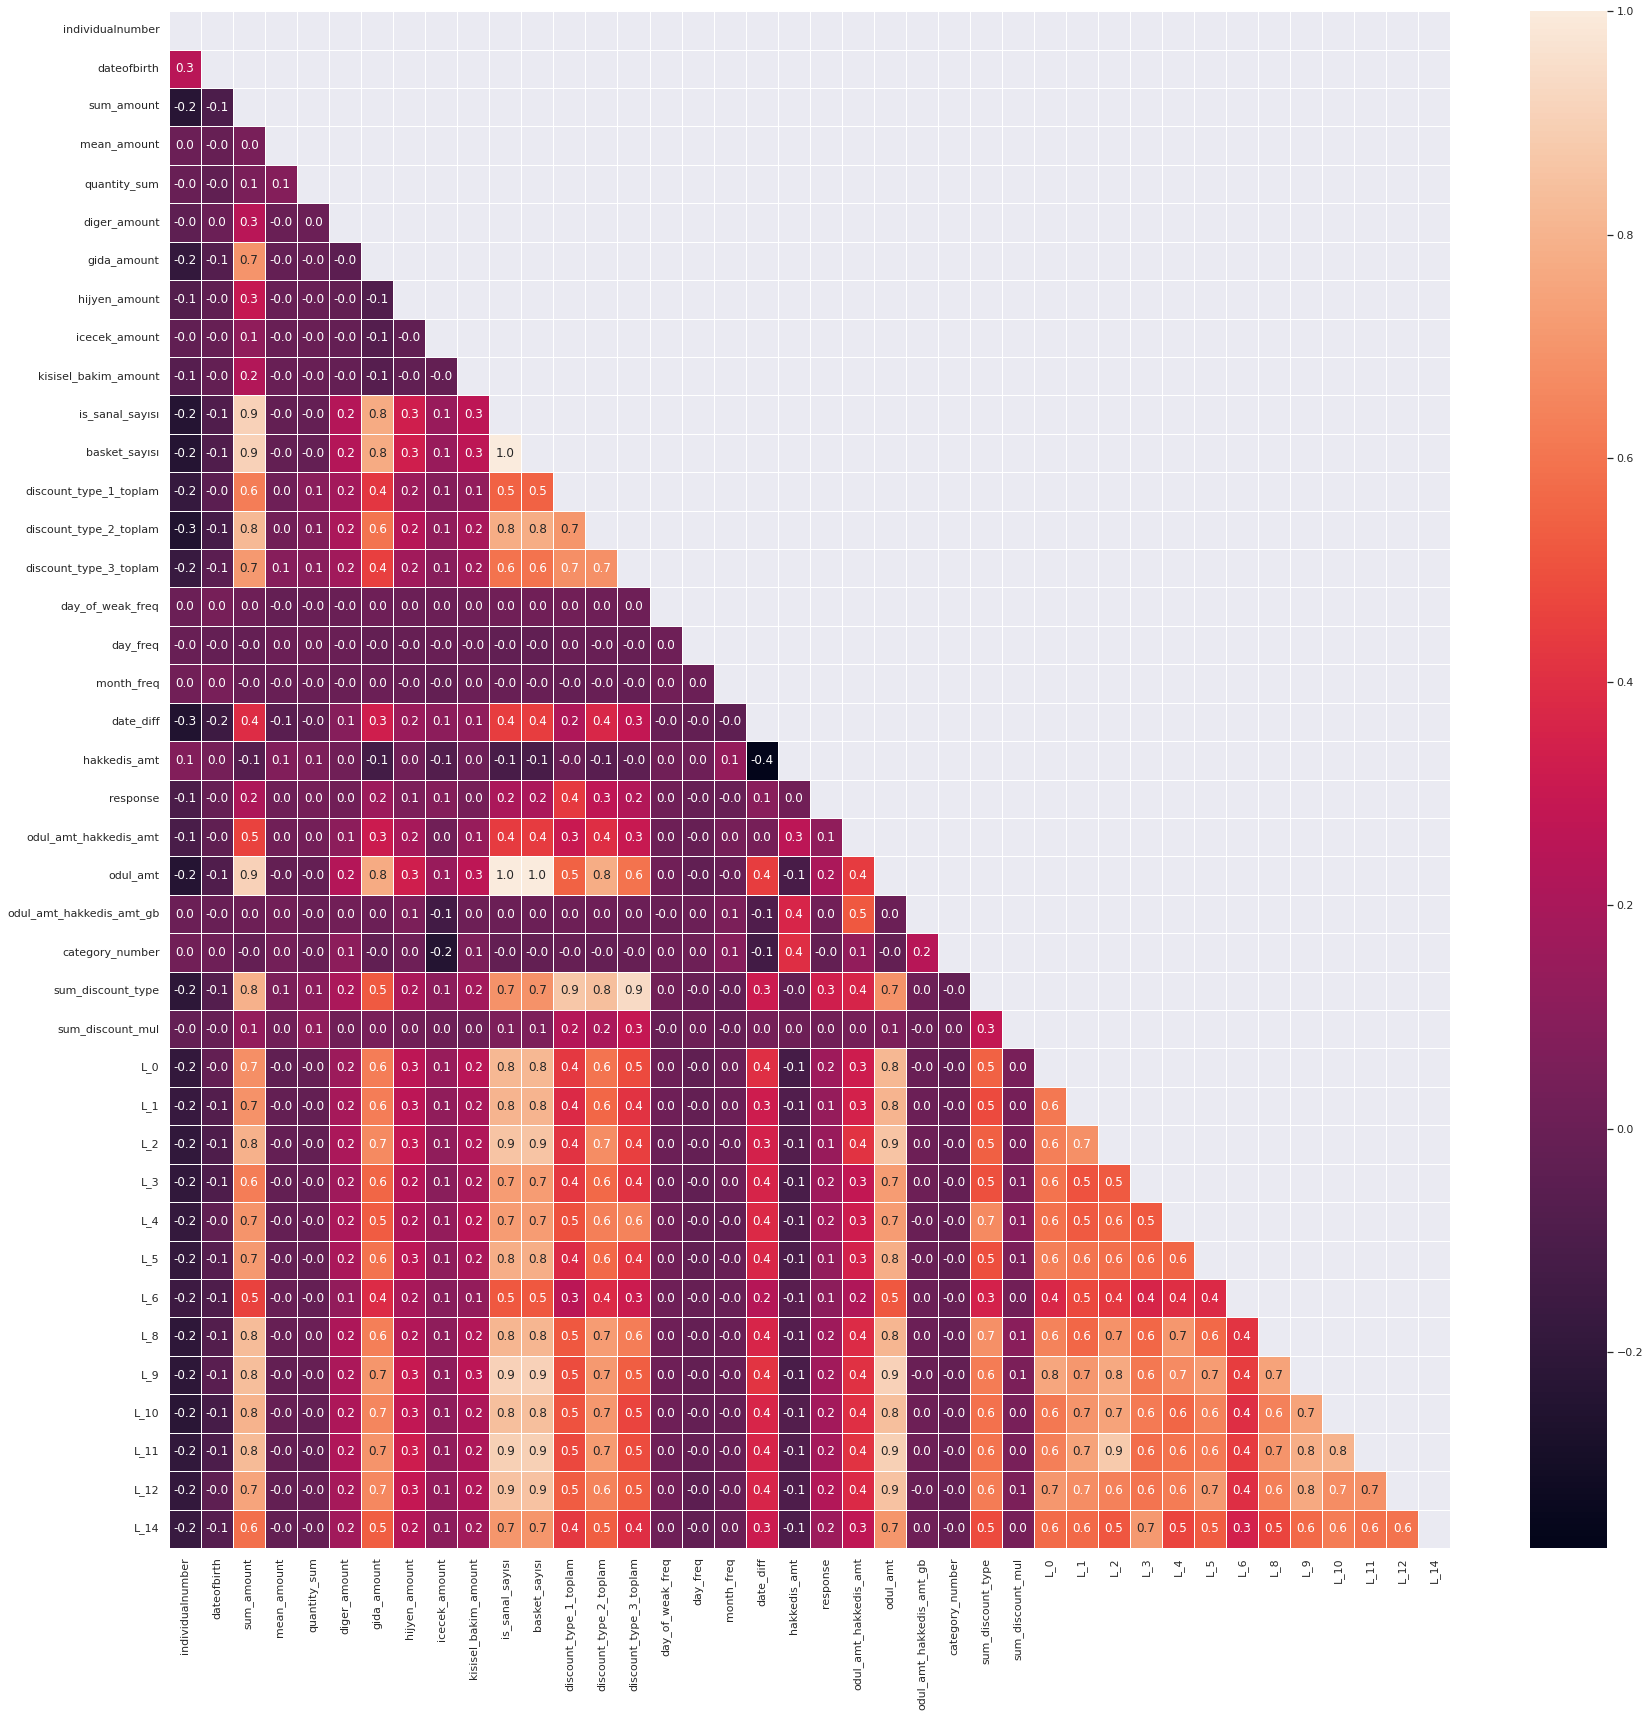

In [119]:
mask = np.triu(np.ones_like(data.select_dtypes([int,float]).corr(), dtype=bool))
sns.set(rc={'figure.figsize':(28.7,28.27)})
sns.heatmap(data.select_dtypes([int,float]).corr(),annot=True,fmt=".1f",linewidth=.5,mask=mask);

In [120]:
data_end=data.copy()

data_end=data_end.astype({'day_of_weak_freq':str,
                 'day_freq':str,
                 'month_freq':str,
                 'category_number':str,
                 'gender':str,
                 'city_code':str})

cat_features=['day_of_weak_freq', 'gender','city_code','day_freq',
              'month_freq','category_number']
data_end['günlük_ort_harcama']=data_end.date_diff/data_end.sum_amount
print(f'data_end shape',data_end.shape)

# -----------------------------
Le=LabelEncoder()
data_end.loc[:,cat_features]=data_end[cat_features].apply(lambda x: Le.fit_transform(x),axis=0)
# ------------------------------------------------------------------------------------------------------------
data_train=data_end[data_end.response.notnull()].drop('response',axis=1)
target_train=data_end[data_end.response.notnull()].response
data_test=data_end[data_end.response.isnull()].drop('response',axis=1)
test_id=data_test.individualnumber
data_test.drop(['individualnumber'],axis=1,inplace=True)
train_id=data_train.individualnumber
data_train.drop(['individualnumber'],axis=1,inplace=True)
print(f'data_train shape',data_train.shape)
print(f'data_test shape',data_test.shape)

data_end shape (26336, 45)
data_train shape (13111, 43)
data_test shape (13225, 43)


# XGBOOST MODEL

 I used the XGBOOST model for train data and used 'optuna' in order to tune the model. when ı do this ,I selected KFold. inside each fold determined the optimum threshold using with calculate_optimum_threshold  function

##  Model optimization with optuna

In [128]:
from sklearn import metrics
def objective(trial,data=data_train,target=target_train):
    
    param = {'use_label_encoder':False,            
              'eval_metric':'logloss',
             "objective": "binary:logistic",
            'tree_method':'gpu_hist',
             'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
             'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
             'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
             'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
             'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02,0.1,0.2,0.5]),
             'n_estimators': 300,
             'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
             'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
             'min_child_weight': trial.suggest_int('min_child_weight', 1, 500),
            'scale_pos_weight':trial.suggest_float("scale_pos_weight", 1.0, 100.0),
            'eval_metric':'auc'
#                'scale_pos_weight':60,
#             'early_stopping_rounds':100

    } 
  
    score_list1=[]
    kf = KFold(n_splits=4, shuffle=True)
    folds=list(kf.split(data_train,target_train))
    thresholds=[]
    for train_index, test_index in folds:
        X_train , X_val = data_train.iloc[train_index], data_train.iloc[test_index]  
        y_train, y_val = target_train.iloc[train_index], target_train.iloc[test_index]  


        model = xgb.XGBClassifier(**param)  
        model.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)],verbose=0)


        preds = model.predict_proba(X_val)[:, 1]
        threshold, val_score = calculate_optimum_threshold(y_val, preds)
        scores = classification_scores(y_val, preds, threshold=threshold)

        score_list1.append( scores['f1'])
        thresholds.append(threshold)
    scores_mean=np.mean(score_list1)
    scores_std=np.std(score_list1)
    trial.set_user_attr("optimum_treshold", np.mean(thresholds))
    trial.set_user_attr("scores_std",scores_std)

    
    print(f"treshold mean : {np.mean(thresholds)}")
    print(f"score std : {scores_std}")

    print('-----------------------')
    print('-----------------------')
    return scores_mean
    


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
gc.collect()

[I 2023-01-01 13:16:51,910] A new study created in memory with name: no-name-ef9b1468-6eab-40bd-adb0-360ec6b682ba


Optimum threshold: 0.58, Score: 0.275
Optimum threshold: 0.54, Score: 0.2544169611307421
Optimum threshold: 0.58, Score: 0.28346456692913385


[I 2023-01-01 13:16:54,906] Trial 0 finished with value: 0.28182300210230526 and parameters: {'lambda': 1.9759848065705294, 'alpha': 8.772349306271463, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.2, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 314, 'scale_pos_weight': 21.440522255349023}. Best is trial 0 with value: 0.28182300210230526.


Optimum threshold: 0.58, Score: 0.314410480349345
treshold mean : 0.5700000000000001
score std : 0.021577088039196984
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.35964912280701755
Optimum threshold: 0.58, Score: 0.3225806451612903
Optimum threshold: 0.58, Score: 0.24000000000000002


[I 2023-01-01 13:17:00,173] Trial 1 finished with value: 0.30576069402459727 and parameters: {'lambda': 2.307823379352947, 'alpha': 0.2727470389870747, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 37, 'scale_pos_weight': 76.60391040030724}. Best is trial 1 with value: 0.30576069402459727.


Optimum threshold: 0.58, Score: 0.3008130081300813
treshold mean : 0.58
score std : 0.043404556175550904
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.24285714285714288
Optimum threshold: 0.58, Score: 0.3055555555555556
Optimum threshold: 0.58, Score: 0.20923076923076922


[I 2023-01-01 13:17:04,412] Trial 2 finished with value: 0.262462814962815 and parameters: {'lambda': 5.617896975753349, 'alpha': 7.765426057987369, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 180, 'scale_pos_weight': 58.263672915497104}. Best is trial 1 with value: 0.30576069402459727.


Optimum threshold: 0.58, Score: 0.2922077922077922
treshold mean : 0.58
score std : 0.03859980904949915
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.58, Score: 0.0


[I 2023-01-01 13:17:07,364] Trial 3 finished with value: 0.0 and parameters: {'lambda': 3.0500482348706255, 'alpha': 5.267592339327208, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 446, 'scale_pos_weight': 6.318924059290816}. Best is trial 1 with value: 0.30576069402459727.


Optimum threshold: 0.58, Score: 0.0
treshold mean : 0.58
score std : 0.0
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3195876288659793
Optimum threshold: 0.58, Score: 0.32863849765258213
Optimum threshold: 0.58, Score: 0.3317073170731707


[I 2023-01-01 13:17:11,973] Trial 4 finished with value: 0.32792174952352543 and parameters: {'lambda': 9.523583983648876, 'alpha': 9.40797804468429, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 175, 'scale_pos_weight': 49.20158468168444}. Best is trial 4 with value: 0.32792174952352543.


Optimum threshold: 0.58, Score: 0.33175355450236965
treshold mean : 0.58
score std : 0.004974548876126006
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2194513715710723
Optimum threshold: 0.56, Score: 0.15422885572139303
Optimum threshold: 0.58, Score: 0.16956521739130434


[I 2023-01-01 13:17:16,271] Trial 5 finished with value: 0.1923933473141295 and parameters: {'lambda': 5.86763803742971, 'alpha': 2.180788446655388, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 406, 'scale_pos_weight': 95.49423528981325}. Best is trial 4 with value: 0.32792174952352543.


Optimum threshold: 0.58, Score: 0.22632794457274827
treshold mean : 0.5750000000000001
score std : 0.03106986281792776
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.1791044776119403
Optimum threshold: 0.58, Score: 0.211864406779661
Optimum threshold: 0.58, Score: 0.17411764705882354


[I 2023-01-01 13:17:19,489] Trial 6 finished with value: 0.18616959204627964 and parameters: {'lambda': 3.562814504794308, 'alpha': 0.10159643415851798, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 388, 'scale_pos_weight': 80.11716012928878}. Best is trial 4 with value: 0.32792174952352543.


Optimum threshold: 0.58, Score: 0.17959183673469387
treshold mean : 0.58
score std : 0.014988792388588761
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3434343434343435
Optimum threshold: 0.58, Score: 0.3283582089552239
Optimum threshold: 0.58, Score: 0.3838383838383838


[I 2023-01-01 13:17:23,022] Trial 7 finished with value: 0.3374371458216937 and parameters: {'lambda': 4.809192265229969, 'alpha': 7.552832634620105, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 142, 'scale_pos_weight': 79.96548547396834}. Best is trial 7 with value: 0.3374371458216937.


Optimum threshold: 0.58, Score: 0.2941176470588235
treshold mean : 0.5750000000000001
score std : 0.03220266812074102
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3316582914572864
Optimum threshold: 0.58, Score: 0.3436123348017621
Optimum threshold: 0.58, Score: 0.3410138248847926


[I 2023-01-01 13:17:26,595] Trial 8 finished with value: 0.3286325162947322 and parameters: {'lambda': 9.931980159277714, 'alpha': 7.49599557746311, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 157, 'scale_pos_weight': 22.64307937024471}. Best is trial 7 with value: 0.3374371458216937.


Optimum threshold: 0.58, Score: 0.2982456140350877
treshold mean : 0.58
score std : 0.018098417811906773
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.2558922558922559
Optimum threshold: 0.58, Score: 0.20817843866171004
Optimum threshold: 0.58, Score: 0.2605633802816901


[I 2023-01-01 13:17:29,358] Trial 9 finished with value: 0.2569160944664898 and parameters: {'lambda': 9.892214619366035, 'alpha': 3.0320485615942157, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.5, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 322, 'scale_pos_weight': 47.499913624285334}. Best is trial 7 with value: 0.3374371458216937.


Optimum threshold: 0.58, Score: 0.303030303030303
treshold mean : 0.5650000000000001
score std : 0.03360145184384111
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.3925233644859813
Optimum threshold: 0.5, Score: 0.47457627118644063
Optimum threshold: 0.42, Score: 0.3853211009174312


[I 2023-01-01 13:17:33,936] Trial 10 finished with value: 0.4177563469381609 and parameters: {'lambda': 6.813574427298308, 'alpha': 5.647791512033318, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 3, 'scale_pos_weight': 99.9034772402587}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.54, Score: 0.41860465116279066
treshold mean : 0.495
score std : 0.03506412696580024
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.4060150375939849
Optimum threshold: 0.48, Score: 0.3943661971830986
Optimum threshold: 0.58, Score: 0.4126984126984127


[I 2023-01-01 13:17:38,028] Trial 11 finished with value: 0.39550292157761197 and parameters: {'lambda': 7.128925831030622, 'alpha': 5.7724648573221655, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 19, 'scale_pos_weight': 97.29507265829352}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.56, Score: 0.36893203883495146
treshold mean : 0.54
score std : 0.01668452464186885
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.38095238095238093
Optimum threshold: 0.48, Score: 0.47058823529411764
Optimum threshold: 0.58, Score: 0.3909774436090225


[I 2023-01-01 13:17:41,971] Trial 12 finished with value: 0.39656701496388025 and parameters: {'lambda': 7.538748214651073, 'alpha': 5.3814125452595185, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 30, 'scale_pos_weight': 97.53204381740291}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.34375
treshold mean : 0.54
score std : 0.04621644250728418
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3617021276595745
Optimum threshold: 0.58, Score: 0.4028776978417266
Optimum threshold: 0.54, Score: 0.36065573770491804


[I 2023-01-01 13:17:45,792] Trial 13 finished with value: 0.3780830843499419 and parameters: {'lambda': 7.77384958568544, 'alpha': 3.772416032680648, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 84, 'scale_pos_weight': 98.95185562348817}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.56, Score: 0.38709677419354843
treshold mean : 0.565
score std : 0.017804968519919133
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.33484162895927605
Optimum threshold: 0.58, Score: 0.34615384615384615
Optimum threshold: 0.58, Score: 0.3015075376884422


[I 2023-01-01 13:17:50,327] Trial 14 finished with value: 0.3281257532003911 and parameters: {'lambda': 7.596031130675744, 'alpha': 5.845521185374069, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 64.87001204915838}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.33
treshold mean : 0.58
score std : 0.01644807983362797
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2889733840304182
Optimum threshold: 0.58, Score: 0.246031746031746
Optimum threshold: 0.58, Score: 0.2608695652173913


[I 2023-01-01 13:17:54,303] Trial 15 finished with value: 0.28428613413734916 and parameters: {'lambda': 0.7436546794386452, 'alpha': 4.308790390461455, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 95, 'scale_pos_weight': 86.1280252048605}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.3412698412698413
treshold mean : 0.58
score std : 0.03633471858787047
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.16901408450704225
Optimum threshold: 0.58, Score: 0.22408963585434175
Optimum threshold: 0.58, Score: 0.23979591836734698


[I 2023-01-01 13:17:57,625] Trial 16 finished with value: 0.20809367608638218 and parameters: {'lambda': 8.416202629096878, 'alpha': 6.59974808698106, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.012, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 248, 'scale_pos_weight': 66.16763147655564}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.19947506561679787
treshold mean : 0.58
score std : 0.026750690733949367
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2805755395683453
Optimum threshold: 0.58, Score: 0.20216606498194947
Optimum threshold: 0.58, Score: 0.2636655948553055


[I 2023-01-01 13:18:02,144] Trial 17 finished with value: 0.2598160855656858 and parameters: {'lambda': 6.4486862238138185, 'alpha': 1.6329551852389845, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 90, 'scale_pos_weight': 89.3661020535388}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.2928571428571428
treshold mean : 0.58
score std : 0.0348604718574705
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2948207171314741
Optimum threshold: 0.58, Score: 0.2527881040892193
Optimum threshold: 0.58, Score: 0.34854771784232363


[I 2023-01-01 13:18:05,087] Trial 18 finished with value: 0.2961321580215682 and parameters: {'lambda': 4.543692526543126, 'alpha': 4.419098382459217, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 236, 'scale_pos_weight': 38.43168097207529}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.2883720930232558
treshold mean : 0.58
score std : 0.03423461847530875
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3802816901408451
Optimum threshold: 0.58, Score: 0.4383561643835616
Optimum threshold: 0.58, Score: 0.43971631205673756


[I 2023-01-01 13:18:09,116] Trial 19 finished with value: 0.4074456845024289 and parameters: {'lambda': 8.509844063657797, 'alpha': 6.5274469825078425, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 56, 'scale_pos_weight': 72.736353395929}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.52, Score: 0.3714285714285714
treshold mean : 0.565
score std : 0.03174888263026752
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.41666666666666663
Optimum threshold: 0.46, Score: 0.3916083916083916
Optimum threshold: 0.48, Score: 0.4328358208955224


[I 2023-01-01 13:18:12,289] Trial 20 finished with value: 0.41255044706537247 and parameters: {'lambda': 8.71517692254424, 'alpha': 6.654573834975154, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 65, 'scale_pos_weight': 71.04343013823299}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.4090909090909091
treshold mean : 0.525
score std : 0.014823779418513908
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.3151515151515151
Optimum threshold: 0.42, Score: 0.4507042253521127
Optimum threshold: 0.38, Score: 0.3614457831325301


[I 2023-01-01 13:18:15,363] Trial 21 finished with value: 0.3858253809090395 and parameters: {'lambda': 8.72062914656716, 'alpha': 6.618397237207974, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 65, 'scale_pos_weight': 71.54810165200799}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.54, Score: 0.41600000000000004
treshold mean : 0.45
score std : 0.051741985327222434
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3958333333333333
Optimum threshold: 0.58, Score: 0.31645569620253167
Optimum threshold: 0.52, Score: 0.379746835443038


[I 2023-01-01 13:18:18,435] Trial 22 finished with value: 0.3593964007996996 and parameters: {'lambda': 8.730708763540667, 'alpha': 6.6047339693355065, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 122, 'scale_pos_weight': 59.89741447462433}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.52, Score: 0.34554973821989526
treshold mean : 0.55
score std : 0.030730377554357983
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.2831050228310502
Optimum threshold: 0.58, Score: 0.33980582524271846
Optimum threshold: 0.58, Score: 0.32191780821917804


[I 2023-01-01 13:18:23,701] Trial 23 finished with value: 0.3058792952207776 and parameters: {'lambda': 6.780868810902877, 'alpha': 8.62857661947384, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 85.55001712855788}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.52, Score: 0.2786885245901639
treshold mean : 0.56
score std : 0.025817866047069312
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2631578947368421
Optimum threshold: 0.58, Score: 0.3153153153153153
Optimum threshold: 0.56, Score: 0.35514018691588783


[I 2023-01-01 13:18:28,285] Trial 24 finished with value: 0.30706406352772564 and parameters: {'lambda': 8.729012455917442, 'alpha': 6.506093438618391, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 65, 'scale_pos_weight': 39.33504972624953}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.29464285714285715
treshold mean : 0.575
score std : 0.03339698647350181
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.29859154929577464
Optimum threshold: 0.58, Score: 0.17575757575757578
Optimum threshold: 0.58, Score: 0.21153846153846156


[I 2023-01-01 13:18:32,002] Trial 25 finished with value: 0.23978585013632508 and parameters: {'lambda': 5.922424760309434, 'alpha': 4.685459452884962, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 218, 'scale_pos_weight': 71.72109169517108}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.2732558139534884
treshold mean : 0.58
score std : 0.04867207519223169
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2831050228310502
Optimum threshold: 0.56, Score: 0.286764705882353
Optimum threshold: 0.58, Score: 0.32258064516129037


[I 2023-01-01 13:18:36,330] Trial 26 finished with value: 0.28657413193021186 and parameters: {'lambda': 8.089879318934324, 'alpha': 8.02649074219361, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 54, 'scale_pos_weight': 56.09414538093375}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.25384615384615383
treshold mean : 0.5750000000000001
score std : 0.024390882419992183
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.21052631578947364
Optimum threshold: 0.52, Score: 0.19540229885057472
Optimum threshold: 0.58, Score: 0.3548387096774193


[I 2023-01-01 13:18:40,159] Trial 27 finished with value: 0.25309505688581857 and parameters: {'lambda': 9.333947049978413, 'alpha': 7.159114169629948, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 112, 'scale_pos_weight': 73.02551410714291}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.2516129032258065
treshold mean : 0.5650000000000001
score std : 0.0622384923320981
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.18991097922848665
Optimum threshold: 0.58, Score: 0.23529411764705882
Optimum threshold: 0.58, Score: 0.1940700808625337


[I 2023-01-01 13:18:43,660] Trial 28 finished with value: 0.22293868544269418 and parameters: {'lambda': 6.6315236078885125, 'alpha': 9.972124216883866, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 199, 'scale_pos_weight': 89.41152671851893}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.2724795640326975
treshold mean : 0.58
score std : 0.0336570240239826
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.28571428571428575
Optimum threshold: 0.58, Score: 0.26666666666666666
Optimum threshold: 0.52, Score: 0.2367601246105919


[I 2023-01-01 13:18:47,924] Trial 29 finished with value: 0.25899413000737975 and parameters: {'lambda': 0.06041873400083819, 'alpha': 3.3299329037678875, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 311, 'scale_pos_weight': 29.29109876372941}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.2468354430379747
treshold mean : 0.565
score std : 0.018808370507527854
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.58, Score: 0.0


[I 2023-01-01 13:18:51,437] Trial 30 finished with value: 0.0 and parameters: {'lambda': 9.144935871912873, 'alpha': 8.681764295611519, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 500, 'scale_pos_weight': 2.7638934512286895}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.0
treshold mean : 0.58
score std : 0.0
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.3728813559322034
Optimum threshold: 0.5, Score: 0.4475524475524475
Optimum threshold: 0.58, Score: 0.40601503759398494


[I 2023-01-01 13:18:55,294] Trial 31 finished with value: 0.405848851491033 and parameters: {'lambda': 7.432259722652743, 'alpha': 5.289410272071914, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 40, 'scale_pos_weight': 92.87690783208433}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.56, Score: 0.3969465648854962
treshold mean : 0.525
score std : 0.02695052880976091
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4251968503937008
Optimum threshold: 0.52, Score: 0.3884892086330935
Optimum threshold: 0.56, Score: 0.4027777777777778


[I 2023-01-01 13:18:59,691] Trial 32 finished with value: 0.4048622278578594 and parameters: {'lambda': 7.206618532532175, 'alpha': 5.78452797968687, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 44, 'scale_pos_weight': 83.53565636839075}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.4029850746268657
treshold mean : 0.56
score std : 0.013128606824399584
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.326530612244898
Optimum threshold: 0.58, Score: 0.28089887640449435
Optimum threshold: 0.56, Score: 0.3317972350230415


[I 2023-01-01 13:19:03,505] Trial 33 finished with value: 0.33980668091810845 and parameters: {'lambda': 8.119948580934913, 'alpha': 6.111363977558953, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 126, 'scale_pos_weight': 91.84180131658928}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.42000000000000004
treshold mean : 0.575
score std : 0.05035251503387407
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.47945205479452063
Optimum threshold: 0.56, Score: 0.40625000000000006
Optimum threshold: 0.58, Score: 0.3943661971830986


[I 2023-01-01 13:19:07,320] Trial 34 finished with value: 0.4013178760025349 and parameters: {'lambda': 5.340535103399855, 'alpha': 4.886109586442124, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 43, 'scale_pos_weight': 76.97888565405901}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.56, Score: 0.3252032520325203
treshold mean : 0.5700000000000001
score std : 0.054706118403542586
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.23529411764705882
Optimum threshold: 0.58, Score: 0.18579234972677597
Optimum threshold: 0.58, Score: 0.1904761904761905


[I 2023-01-01 13:19:10,456] Trial 35 finished with value: 0.1974340943066043 and parameters: {'lambda': 6.075092498989236, 'alpha': 7.158684159573145, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 288, 'scale_pos_weight': 65.89045439249111}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.17817371937639198
treshold mean : 0.58
score std : 0.022295100652202502
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.23602484472049692
Optimum threshold: 0.58, Score: 0.26666666666666666
Optimum threshold: 0.58, Score: 0.2528735632183908


[I 2023-01-01 13:19:15,039] Trial 36 finished with value: 0.2618395969188658 and parameters: {'lambda': 7.262486984054317, 'alpha': 5.140694120122505, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 77, 'scale_pos_weight': 91.94828419280189}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.2917933130699088
treshold mean : 0.58
score std : 0.02041639601514328
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4
Optimum threshold: 0.44, Score: 0.47154471544715443
Optimum threshold: 0.36, Score: 0.4193548387096774


[I 2023-01-01 13:19:22,131] Trial 37 finished with value: 0.41713048294480237 and parameters: {'lambda': 4.128842407864456, 'alpha': 8.18393271355911, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 80.15523639769755}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.32, Score: 0.3776223776223776
treshold mean : 0.42
score std : 0.03471383113932663
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.34977578475336324
Optimum threshold: 0.58, Score: 0.28699551569506726
Optimum threshold: 0.58, Score: 0.2938388625592417


[I 2023-01-01 13:19:25,431] Trial 38 finished with value: 0.31367105927043654 and parameters: {'lambda': 3.7559801737072482, 'alpha': 9.127106436538064, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.2, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 149, 'scale_pos_weight': 53.488678693635876}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.324074074074074
treshold mean : 0.5700000000000001
score std : 0.02508323429422106
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.39361702127659576
Optimum threshold: 0.54, Score: 0.3448275862068966
Optimum threshold: 0.58, Score: 0.32


[I 2023-01-01 13:19:32,691] Trial 39 finished with value: 0.35687305663277785 and parameters: {'lambda': 2.546723858370841, 'alpha': 8.04480679720888, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 12, 'scale_pos_weight': 79.86789470568273}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.56, Score: 0.36904761904761907
treshold mean : 0.5650000000000001
score std : 0.02740006647329449
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.35714285714285715
Optimum threshold: 0.54, Score: 0.26373626373626374
Optimum threshold: 0.58, Score: 0.33519553072625696


[I 2023-01-01 13:19:35,937] Trial 40 finished with value: 0.32609731458673774 and parameters: {'lambda': 4.263811074891846, 'alpha': 7.101904846123281, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.5, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 101, 'scale_pos_weight': 61.01437812705154}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.34831460674157305
treshold mean : 0.5700000000000001
score std : 0.03684125399397373
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.36220472440944884
Optimum threshold: 0.58, Score: 0.42857142857142855
Optimum threshold: 0.58, Score: 0.4810126582278481


[I 2023-01-01 13:19:41,468] Trial 41 finished with value: 0.4005160101416309 and parameters: {'lambda': 4.971058697590065, 'alpha': 6.21785572826418, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 30, 'scale_pos_weight': 82.56164292606319}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.3302752293577982
treshold mean : 0.58
score std : 0.058455835371592
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4347826086956521
Optimum threshold: 0.32, Score: 0.4409448818897638
Optimum threshold: 0.38, Score: 0.33599999999999997


[I 2023-01-01 13:19:48,366] Trial 42 finished with value: 0.4077705823237733 and parameters: {'lambda': 5.451920319482945, 'alpha': 7.9324832359143365, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 74.93749365468841}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.44, Score: 0.4193548387096774
treshold mean : 0.42500000000000004
score std : 0.04217640099486038
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.4626865671641791
Optimum threshold: 0.3, Score: 0.4305555555555555
Optimum threshold: 0.3, Score: 0.37762237762237755


[I 2023-01-01 13:19:54,746] Trial 43 finished with value: 0.40902047291161503 and parameters: {'lambda': 3.8189076315535746, 'alpha': 8.194672250182728, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 74.69348838104143}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.44, Score: 0.3652173913043478
treshold mean : 0.365
score std : 0.039523283653092975
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3741007194244605
Optimum threshold: 0.52, Score: 0.457516339869281
Optimum threshold: 0.58, Score: 0.42335766423357657


[I 2023-01-01 13:19:59,563] Trial 44 finished with value: 0.40426092226113985 and parameters: {'lambda': 3.2765534426820926, 'alpha': 8.43464079318496, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 20, 'scale_pos_weight': 76.40037014750705}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.3620689655172414
treshold mean : 0.56
score std : 0.038375200675722775
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.3431952662721893
Optimum threshold: 0.58, Score: 0.40268456375838924
Optimum threshold: 0.58, Score: 0.3592814371257485


[I 2023-01-01 13:20:08,544] Trial 45 finished with value: 0.36386093825800836 and parameters: {'lambda': 4.226065831182267, 'alpha': 9.571162373260982, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 67.15858941513517}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.54, Score: 0.3502824858757062
treshold mean : 0.56
score std : 0.023128392158438652
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.29870129870129875
Optimum threshold: 0.58, Score: 0.4113475177304965
Optimum threshold: 0.52, Score: 0.4264705882352941


[I 2023-01-01 13:20:12,818] Trial 46 finished with value: 0.38640257843949966 and parameters: {'lambda': 5.369793190965443, 'alpha': 7.722495446857263, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 37, 'scale_pos_weight': 46.119823879857066}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.4090909090909091
treshold mean : 0.56
score std : 0.051073403598872406
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.20930232558139533
Optimum threshold: 0.58, Score: 0.24040920716112532
Optimum threshold: 0.58, Score: 0.21108179419525064


[I 2023-01-01 13:20:16,069] Trial 47 finished with value: 0.2097275938209568 and parameters: {'lambda': 1.6394273618939526, 'alpha': 8.142877639924718, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.2, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 383, 'scale_pos_weight': 77.58562276749063}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.17811704834605596
treshold mean : 0.58
score std : 0.022037483375522363
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3541666666666667
Optimum threshold: 0.58, Score: 0.26609442060085836
Optimum threshold: 0.58, Score: 0.30697674418604654


[I 2023-01-01 13:20:22,032] Trial 48 finished with value: 0.32728684479806625 and parameters: {'lambda': 2.8310595241739693, 'alpha': 9.082671909305802, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 21, 'scale_pos_weight': 86.55419072488152}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.3819095477386934
treshold mean : 0.5750000000000001
score std : 0.044337279647687806
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.31527093596059114
Optimum threshold: 0.58, Score: 0.35555555555555557
Optimum threshold: 0.58, Score: 0.36942675159235666


[I 2023-01-01 13:20:26,319] Trial 49 finished with value: 0.3554580476192311 and parameters: {'lambda': 4.036295351820385, 'alpha': 7.475781597041995, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 71, 'scale_pos_weight': 63.4263165603084}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.56, Score: 0.3815789473684211
treshold mean : 0.56
score std : 0.024962169104755745
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3517587939698492
Optimum threshold: 0.58, Score: 0.2872340425531915
Optimum threshold: 0.58, Score: 0.37442922374429227


[I 2023-01-01 13:20:33,808] Trial 50 finished with value: 0.3408555150668332 and parameters: {'lambda': 2.041385311738681, 'alpha': 7.0105433695133925, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 2, 'scale_pos_weight': 99.80513632729915}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.35
treshold mean : 0.58
score std : 0.032422828857226464
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.25609756097560976
Optimum threshold: 0.52, Score: 0.3768115942028985
Optimum threshold: 0.58, Score: 0.3783783783783784


[I 2023-01-01 13:20:37,339] Trial 51 finished with value: 0.3370915463105699 and parameters: {'lambda': 3.3967385236472953, 'alpha': 7.566546193558402, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 59, 'scale_pos_weight': 70.00492669719392}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.33707865168539325
treshold mean : 0.56
score std : 0.04960420983514251
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3515625
Optimum threshold: 0.58, Score: 0.26556016597510373
Optimum threshold: 0.56, Score: 0.2677165354330709


[I 2023-01-01 13:20:40,803] Trial 52 finished with value: 0.294006735217944 and parameters: {'lambda': 6.268605108132114, 'alpha': 8.348013772571939, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 171, 'scale_pos_weight': 74.66251315053883}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.29118773946360155
treshold mean : 0.575
score std : 0.03471669160190313
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3941605839416058
Optimum threshold: 0.58, Score: 0.5343511450381679
Optimum threshold: 0.42, Score: 0.35668789808917195


[I 2023-01-01 13:20:45,351] Trial 53 finished with value: 0.39341529138262105 and parameters: {'lambda': 4.52525186934797, 'alpha': 5.6641367151465225, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 34, 'scale_pos_weight': 69.21706650260357}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.3, Score: 0.2884615384615385
treshold mean : 0.47
score std : 0.08976032249408357
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.24313725490196078
Optimum threshold: 0.58, Score: 0.2677824267782427
Optimum threshold: 0.58, Score: 0.3295019157088122


[I 2023-01-01 13:20:49,871] Trial 54 finished with value: 0.2955220660139206 and parameters: {'lambda': 5.499826631399806, 'alpha': 1.0155253927062966, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 85, 'scale_pos_weight': 80.47712694863591}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.34166666666666673
treshold mean : 0.58
score std : 0.04122381100423066
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.45378151260504196
Optimum threshold: 0.52, Score: 0.40875912408759124
Optimum threshold: 0.54, Score: 0.425531914893617


[I 2023-01-01 13:20:55,074] Trial 55 finished with value: 0.402232041639878 and parameters: {'lambda': 9.869883510299344, 'alpha': 6.785901287263123, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 20, 'scale_pos_weight': 10.534313874250344}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.42, Score: 0.32085561497326204
treshold mean : 0.515
score std : 0.0496612466434718
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.30578512396694213
Optimum threshold: 0.58, Score: 0.2992700729927007
Optimum threshold: 0.58, Score: 0.24630541871921183


[I 2023-01-01 13:20:59,676] Trial 56 finished with value: 0.30119356757433213 and parameters: {'lambda': 3.7700257497730205, 'alpha': 6.23836475964241, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 57, 'scale_pos_weight': 57.762744144463994}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.35341365461847385
treshold mean : 0.58
score std : 0.0379619170918424
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4067796610169492
Optimum threshold: 0.46, Score: 0.3222222222222222
Optimum threshold: 0.58, Score: 0.4


[I 2023-01-01 13:21:03,984] Trial 57 finished with value: 0.3786360129784675 and parameters: {'lambda': 7.822011608531701, 'alpha': 7.949622573145407, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 103, 'scale_pos_weight': 51.90169165222758}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.3855421686746988
treshold mean : 0.55
score std : 0.03346152880682591
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.27906976744186046
Optimum threshold: 0.58, Score: 0.2824858757062147
Optimum threshold: 0.58, Score: 0.32352941176470584


[I 2023-01-01 13:21:07,003] Trial 58 finished with value: 0.3005981868051183 and parameters: {'lambda': 4.708968298066826, 'alpha': 8.946452877563152, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.5, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 131, 'scale_pos_weight': 95.41835114874912}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.52, Score: 0.3173076923076923
treshold mean : 0.565
score std : 0.019978596709425832
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.40310077519379844
Optimum threshold: 0.58, Score: 0.44799999999999995
Optimum threshold: 0.5, Score: 0.39790575916230364


[I 2023-01-01 13:21:11,162] Trial 59 finished with value: 0.4015373478747398 and parameters: {'lambda': 6.898726290542626, 'alpha': 7.407395781143579, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 52, 'scale_pos_weight': 63.289001511683}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.35714285714285715
treshold mean : 0.555
score std : 0.032191930632591875
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3153153153153153
Optimum threshold: 0.58, Score: 0.3333333333333333
Optimum threshold: 0.56, Score: 0.30392156862745096


[I 2023-01-01 13:21:17,781] Trial 60 finished with value: 0.31213358570915944 and parameters: {'lambda': 9.082257988120647, 'alpha': 9.53280078357054, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 18, 'scale_pos_weight': 74.17083793307641}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.58, Score: 0.29596412556053814
treshold mean : 0.5700000000000001
score std : 0.014039599074256707
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.396551724137931
Optimum threshold: 0.58, Score: 0.37333333333333335
Optimum threshold: 0.48, Score: 0.38028169014084506


[I 2023-01-01 13:21:21,613] Trial 61 finished with value: 0.3915879296775938 and parameters: {'lambda': 8.428494235571975, 'alpha': 5.377447220990505, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 37, 'scale_pos_weight': 95.27392258205757}. Best is trial 10 with value: 0.4177563469381609.


Optimum threshold: 0.44, Score: 0.41618497109826585
treshold mean : 0.52
score std : 0.01651298763283736
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.40740740740740744
Optimum threshold: 0.32, Score: 0.463768115942029
Optimum threshold: 0.58, Score: 0.396039603960396


[I 2023-01-01 13:21:26,423] Trial 62 finished with value: 0.42958573671467615 and parameters: {'lambda': 7.420995937256056, 'alpha': 4.108036540144469, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 90.27143628187407}. Best is trial 62 with value: 0.42958573671467615.


Optimum threshold: 0.3, Score: 0.4511278195488722
treshold mean : 0.43
score std : 0.028503147616129036
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.44827586206896547
Optimum threshold: 0.4, Score: 0.4090909090909091
Optimum threshold: 0.58, Score: 0.45283018867924524


[I 2023-01-01 13:21:31,294] Trial 63 finished with value: 0.4209558333663734 and parameters: {'lambda': 7.981250020957476, 'alpha': 3.8312893603305227, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 87.1839788754708}. Best is trial 62 with value: 0.42958573671467615.


Optimum threshold: 0.52, Score: 0.37362637362637363
treshold mean : 0.52
score std : 0.032183896137138276
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.4032258064516129
Optimum threshold: 0.42, Score: 0.46296296296296297
Optimum threshold: 0.38, Score: 0.4347826086956521


[I 2023-01-01 13:21:36,166] Trial 64 finished with value: 0.4305060024222938 and parameters: {'lambda': 7.8501083273176135, 'alpha': 3.9481911535804928, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 88.20973622850705}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.44, Score: 0.42105263157894735
treshold mean : 0.415
score std : 0.021824979732272785
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.2516129032258065
Optimum threshold: 0.58, Score: 0.2510822510822511
Optimum threshold: 0.58, Score: 0.2622950819672131


[I 2023-01-01 13:21:40,735] Trial 65 finished with value: 0.2841329345628888 and parameters: {'lambda': 8.03339528287336, 'alpha': 3.605798445167802, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 20, 'scale_pos_weight': 88.3228686457034}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.58, Score: 0.3715415019762846
treshold mean : 0.5650000000000001
score std : 0.050663225272269075
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4484848484848485
Optimum threshold: 0.58, Score: 0.3684210526315789
Optimum threshold: 0.56, Score: 0.39024390243902435


[I 2023-01-01 13:21:43,750] Trial 66 finished with value: 0.3870587687183203 and parameters: {'lambda': 8.993542463911345, 'alpha': 3.901920743235901, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 78, 'scale_pos_weight': 83.06048579902}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.58, Score: 0.34108527131782945
treshold mean : 0.56
score std : 0.03951023689015787
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.5034013605442177
Optimum threshold: 0.54, Score: 0.37398373983739835
Optimum threshold: 0.58, Score: 0.38260869565217387


[I 2023-01-01 13:21:47,773] Trial 67 finished with value: 0.4297525473691032 and parameters: {'lambda': 7.771497436439105, 'alpha': 2.619393843487851, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 28, 'scale_pos_weight': 89.76132575638502}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.58, Score: 0.4590163934426229
treshold mean : 0.5700000000000001
score std : 0.053882332487870575
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3153153153153153
Optimum threshold: 0.58, Score: 0.34615384615384615
Optimum threshold: 0.58, Score: 0.35874439461883406


[I 2023-01-01 13:21:52,088] Trial 68 finished with value: 0.33333621730482715 and parameters: {'lambda': 7.702237756742564, 'alpha': 2.603265773582109, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 27, 'scale_pos_weight': 90.85519728676447}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.58, Score: 0.31313131313131315
treshold mean : 0.58
score std : 0.019639616498977868
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.30115830115830117
Optimum threshold: 0.58, Score: 0.2702702702702703
Optimum threshold: 0.58, Score: 0.28125


[I 2023-01-01 13:21:56,670] Trial 69 finished with value: 0.2767435260186549 and parameters: {'lambda': 6.958038435314531, 'alpha': 4.244089703582552, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 50, 'scale_pos_weight': 94.72619451046084}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.58, Score: 0.2542955326460481
treshold mean : 0.58
score std : 0.017045563933943512
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3918918918918919
Optimum threshold: 0.58, Score: 0.38888888888888884
Optimum threshold: 0.58, Score: 0.368421052631579


[I 2023-01-01 13:22:00,685] Trial 70 finished with value: 0.38593991413540285 and parameters: {'lambda': 6.580269081540778, 'alpha': 2.582213804711993, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 66, 'scale_pos_weight': 86.89909604096107}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.58, Score: 0.3945578231292517
treshold mean : 0.5750000000000001
score std : 0.010311417884157114
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3760683760683761
Optimum threshold: 0.58, Score: 0.3859649122807018
Optimum threshold: 0.54, Score: 0.49599999999999994


[I 2023-01-01 13:22:04,829] Trial 71 finished with value: 0.4256194331983806 and parameters: {'lambda': 8.29424912002256, 'alpha': 3.1559866393755382, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 12, 'scale_pos_weight': 97.97970834741434}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.38, Score: 0.4444444444444445
treshold mean : 0.52
score std : 0.04831043759800574
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.38596491228070173
Optimum threshold: 0.52, Score: 0.4409448818897638
Optimum threshold: 0.58, Score: 0.46428571428571425


[I 2023-01-01 13:22:09,051] Trial 72 finished with value: 0.4296691061216785 and parameters: {'lambda': 8.232578797516574, 'alpha': 3.298560879889401, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 96.92535069826269}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.52, Score: 0.42748091603053434
treshold mean : 0.55
score std : 0.028461805174299724
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.40625
Optimum threshold: 0.42, Score: 0.4788732394366197
Optimum threshold: 0.58, Score: 0.33333333333333337


[I 2023-01-01 13:22:13,163] Trial 73 finished with value: 0.4053604118492047 and parameters: {'lambda': 8.050041519388817, 'alpha': 3.0792080503896644, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 98.43211104823648}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.38, Score: 0.4029850746268657
treshold mean : 0.475
score std : 0.051474434075146375
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.41600000000000004
Optimum threshold: 0.42, Score: 0.391304347826087
Optimum threshold: 0.58, Score: 0.39062500000000006


[I 2023-01-01 13:22:17,023] Trial 74 finished with value: 0.416968675754336 and parameters: {'lambda': 7.468791487342823, 'alpha': 1.9341756220886233, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 34, 'scale_pos_weight': 96.63293417013101}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.36, Score: 0.46994535519125685
treshold mean : 0.46499999999999997
score std : 0.03224947238769032
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.3725490196078431
Optimum threshold: 0.58, Score: 0.41441441441441446
Optimum threshold: 0.34, Score: 0.3866666666666666


[I 2023-01-01 13:22:21,243] Trial 75 finished with value: 0.3994681312328371 and parameters: {'lambda': 8.21069069208476, 'alpha': 4.040184679867447, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 16, 'scale_pos_weight': 92.93301630813471}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.34, Score: 0.42424242424242425
treshold mean : 0.45000000000000007
score std : 0.020770610491669398
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.42424242424242425
Optimum threshold: 0.5, Score: 0.42622950819672134
Optimum threshold: 0.58, Score: 0.3577235772357724


[I 2023-01-01 13:22:25,073] Trial 76 finished with value: 0.40945628482613694 and parameters: {'lambda': 7.781415955055126, 'alpha': 3.4767827236828044, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 43, 'scale_pos_weight': 99.81167699855334}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.58, Score: 0.42962962962962964
treshold mean : 0.56
score std : 0.02992995078624491
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.4615384615384615
Optimum threshold: 0.36, Score: 0.4
Optimum threshold: 0.32, Score: 0.4426229508196721


[I 2023-01-01 13:22:30,415] Trial 77 finished with value: 0.4260403530895334 and parameters: {'lambda': 8.547962974356615, 'alpha': 2.700988450046148, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 88.7355018896873}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.46, Score: 0.39999999999999997
treshold mean : 0.41
score std : 0.02688539672845933
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3383084577114428
Optimum threshold: 0.58, Score: 0.2987551867219917
Optimum threshold: 0.58, Score: 0.3097345132743363


[I 2023-01-01 13:22:34,875] Trial 78 finished with value: 0.3160646187920221 and parameters: {'lambda': 9.648341132598686, 'alpha': 2.640329208682917, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 25, 'scale_pos_weight': 88.43380050361638}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.58, Score: 0.31746031746031744
treshold mean : 0.58
score std : 0.014460489437583445
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.30097087378640774
Optimum threshold: 0.56, Score: 0.26865671641791045
Optimum threshold: 0.58, Score: 0.431924882629108


[I 2023-01-01 13:22:39,336] Trial 79 finished with value: 0.32851311820835655 and parameters: {'lambda': 8.553954982487712, 'alpha': 4.604103599636963, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 84.82207905248453}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.58, Score: 0.3125
treshold mean : 0.5750000000000001
score std : 0.061829962474647934
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.24313725490196078
Optimum threshold: 0.58, Score: 0.311284046692607
Optimum threshold: 0.58, Score: 0.29927007299270075


[I 2023-01-01 13:22:43,983] Trial 80 finished with value: 0.28664460096899286 and parameters: {'lambda': 7.186202570870018, 'alpha': 3.0414452699003696, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 46, 'scale_pos_weight': 93.49288560191442}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.56, Score: 0.2928870292887029
treshold mean : 0.575
score std : 0.025972879617552846
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.39215686274509803
Optimum threshold: 0.58, Score: 0.39999999999999997
Optimum threshold: 0.58, Score: 0.46956521739130436


[I 2023-01-01 13:22:48,593] Trial 81 finished with value: 0.41837169650468886 and parameters: {'lambda': 8.856049650843893, 'alpha': 2.082703467274001, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 3, 'scale_pos_weight': 89.16595114073758}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.3, Score: 0.4117647058823529
treshold mean : 0.5
score std : 0.03036925109117507
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.384
Optimum threshold: 0.58, Score: 0.4122137404580153
Optimum threshold: 0.58, Score: 0.3970588235294118


[I 2023-01-01 13:22:52,599] Trial 82 finished with value: 0.38498480766352344 and parameters: {'lambda': 9.498759338519172, 'alpha': 1.3266544560971834, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 30, 'scale_pos_weight': 90.11614323801452}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.3, Score: 0.3466666666666666
treshold mean : 0.5099999999999999
score std : 0.024271621370675935
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.396551724137931
Optimum threshold: 0.56, Score: 0.42424242424242425
Optimum threshold: 0.58, Score: 0.42857142857142855


[I 2023-01-01 13:22:56,775] Trial 83 finished with value: 0.4147035989623554 and parameters: {'lambda': 8.265003942405361, 'alpha': 1.9634906546890591, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 97.28819777815629}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.48, Score: 0.40944881889763785
treshold mean : 0.52
score std : 0.012653153351636226
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.26618705035971224
Optimum threshold: 0.58, Score: 0.26392961876832843
Optimum threshold: 0.58, Score: 0.24


[I 2023-01-01 13:22:59,790] Trial 84 finished with value: 0.2613024014827537 and parameters: {'lambda': 8.838249030274651, 'alpha': 3.2760519498130067, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 279, 'scale_pos_weight': 90.94312499861272}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.58, Score: 0.27509293680297403
treshold mean : 0.58
score std : 0.012987813890985146
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.3972602739726027
Optimum threshold: 0.5, Score: 0.39682539682539686
Optimum threshold: 0.58, Score: 0.42477876106194695


[I 2023-01-01 13:23:04,822] Trial 85 finished with value: 0.42576873954393396 and parameters: {'lambda': 7.874137012974393, 'alpha': 2.753781258636449, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 9, 'scale_pos_weight': 87.79761185283728}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.54, Score: 0.4842105263157895
treshold mean : 0.515
score std : 0.035590982690269654
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.4070796460176991
Optimum threshold: 0.58, Score: 0.4166666666666667
Optimum threshold: 0.56, Score: 0.41891891891891897


[I 2023-01-01 13:23:08,461] Trial 86 finished with value: 0.40368956371477466 and parameters: {'lambda': 7.908006547636574, 'alpha': 2.3494608181216288, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.2, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 30, 'scale_pos_weight': 82.14709705366158}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.54, Score: 0.372093023255814
treshold mean : 0.555
score std : 0.018776131709921918
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3333333333333333
Optimum threshold: 0.58, Score: 0.33472803347280333
Optimum threshold: 0.58, Score: 0.34615384615384615


[I 2023-01-01 13:23:13,685] Trial 87 finished with value: 0.33087339086886164 and parameters: {'lambda': 7.511463088796876, 'alpha': 3.7158164634343844, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 85.85688018228286}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.54, Score: 0.30927835051546393
treshold mean : 0.57
score std : 0.013423372043882265
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.20417633410672853
Optimum threshold: 0.58, Score: 0.2233009708737864
Optimum threshold: 0.58, Score: 0.17518248175182483


[I 2023-01-01 13:23:16,644] Trial 88 finished with value: 0.19643959457040888 and parameters: {'lambda': 8.30725512411496, 'alpha': 2.908945406164875, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 385, 'scale_pos_weight': 88.96723647925396}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.58, Score: 0.18309859154929578
treshold mean : 0.58
score std : 0.018783223116360128
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.392638036809816
Optimum threshold: 0.52, Score: 0.24468085106382978
Optimum threshold: 0.58, Score: 0.3708609271523179


[I 2023-01-01 13:23:20,406] Trial 89 finished with value: 0.34195723445824533 and parameters: {'lambda': 8.554198886220252, 'alpha': 4.112664948927395, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 49, 'scale_pos_weight': 93.16240986580867}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.42, Score: 0.35964912280701755
treshold mean : 0.525
score std : 0.057401360737344684
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.21218961625282168
Optimum threshold: 0.58, Score: 0.19111111111111112
Optimum threshold: 0.58, Score: 0.17831325301204817


[I 2023-01-01 13:23:23,188] Trial 90 finished with value: 0.19095905064955082 and parameters: {'lambda': 9.41355967342977, 'alpha': 2.3461019027136816, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 365, 'scale_pos_weight': 78.79634916957033}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.58, Score: 0.18222222222222223
treshold mean : 0.58
score std : 0.013105422609324758
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2077922077922078
Optimum threshold: 0.58, Score: 0.2295918367346939
Optimum threshold: 0.58, Score: 0.19815668202764974


[I 2023-01-01 13:23:26,277] Trial 91 finished with value: 0.21051561642124655 and parameters: {'lambda': 8.868743601217258, 'alpha': 3.1983573804394783, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 441, 'scale_pos_weight': 96.75374657520948}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.58, Score: 0.20652173913043478
treshold mean : 0.58
score std : 0.011619094749239249
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.4603174603174604
Optimum threshold: 0.58, Score: 0.32608695652173914
Optimum threshold: 0.42, Score: 0.47887323943661975


[I 2023-01-01 13:23:30,867] Trial 92 finished with value: 0.4163194140689548 and parameters: {'lambda': 7.354423201033121, 'alpha': 2.8486764853093502, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 4, 'scale_pos_weight': 94.5737264999691}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.3, Score: 0.39999999999999997
treshold mean : 0.415
score std : 0.059701400344502054
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.3880597014925373
Optimum threshold: 0.54, Score: 0.4406779661016949
Optimum threshold: 0.5, Score: 0.4962406015037594


[I 2023-01-01 13:23:37,430] Trial 93 finished with value: 0.42526166129159193 and parameters: {'lambda': 9.211768299094826, 'alpha': 4.939164216833839, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 25, 'scale_pos_weight': 84.8836722713163}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.48, Score: 0.37606837606837606
treshold mean : 0.505
score std : 0.047643566017836016
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.38333333333333336
Optimum threshold: 0.56, Score: 0.4822695035460992
Optimum threshold: 0.58, Score: 0.3119266055045871


[I 2023-01-01 13:23:43,619] Trial 94 finished with value: 0.41223950345314775 and parameters: {'lambda': 9.320914438640257, 'alpha': 4.876959817811745, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 26, 'scale_pos_weight': 84.01610736543874}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.54, Score: 0.4714285714285714
treshold mean : 0.555
score std : 0.06947264002226361
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3284671532846716
Optimum threshold: 0.58, Score: 0.2825278810408922
Optimum threshold: 0.58, Score: 0.20202020202020204


[I 2023-01-01 13:23:48,998] Trial 95 finished with value: 0.269455899678776 and parameters: {'lambda': 8.594848602756498, 'alpha': 4.378662809561235, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 73, 'scale_pos_weight': 87.79415906560736}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.56, Score: 0.26480836236933797
treshold mean : 0.575
score std : 0.04533866360682694
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.26905829596412556
Optimum threshold: 0.58, Score: 0.3389830508474576
Optimum threshold: 0.58, Score: 0.3793103448275862


[I 2023-01-01 13:23:57,303] Trial 96 finished with value: 0.31995113045696216 and parameters: {'lambda': 9.205163617700938, 'alpha': 3.4766530561529727, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 39, 'scale_pos_weight': 81.64824350462459}. Best is trial 64 with value: 0.4305060024222938.


Optimum threshold: 0.58, Score: 0.2924528301886793
treshold mean : 0.5750000000000001
score std : 0.04252048754661616
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.5
Optimum threshold: 0.56, Score: 0.36190476190476184
Optimum threshold: 0.58, Score: 0.3636363636363636


[I 2023-01-01 13:24:04,288] Trial 97 finished with value: 0.4400059710404538 and parameters: {'lambda': 9.79184194882699, 'alpha': 2.073116602847908, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 91.68288477007901}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.54, Score: 0.5344827586206896
treshold mean : 0.5650000000000001
score std : 0.07819408977952207
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4029850746268657
Optimum threshold: 0.52, Score: 0.32558139534883723
Optimum threshold: 0.56, Score: 0.4171779141104295


[I 2023-01-01 13:24:09,833] Trial 98 finished with value: 0.38310276268819976 and parameters: {'lambda': 9.671944731468944, 'alpha': 1.6338949520523045, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 59, 'scale_pos_weight': 85.30549182904655}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.3866666666666666
treshold mean : 0.56
score std : 0.03492073662106771
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.3741007194244605
Optimum threshold: 0.56, Score: 0.4375
Optimum threshold: 0.52, Score: 0.5123966942148761


[I 2023-01-01 13:24:16,120] Trial 99 finished with value: 0.4282215756320564 and parameters: {'lambda': 9.871616266954899, 'alpha': 3.872517868738426, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 91.12600704611575}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.56, Score: 0.3888888888888889
treshold mean : 0.535
score std : 0.053962179047604315
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.2625
Optimum threshold: 0.58, Score: 0.4736842105263158
Optimum threshold: 0.56, Score: 0.3285024154589372


[I 2023-01-01 13:24:23,997] Trial 100 finished with value: 0.34775060386473433 and parameters: {'lambda': 9.981714481703321, 'alpha': 4.64507789165843, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.018, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 17, 'scale_pos_weight': 91.30829949283196}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.3263157894736843
treshold mean : 0.5700000000000001
score std : 0.07739005551584067
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.3972602739726027
Optimum threshold: 0.4, Score: 0.41530054644808745
Optimum threshold: 0.58, Score: 0.38260869565217387


[I 2023-01-01 13:24:29,758] Trial 101 finished with value: 0.40803607649720763 and parameters: {'lambda': 9.813463881311632, 'alpha': 3.8708065706409474, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 27, 'scale_pos_weight': 93.82159740467989}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.43697478991596633
treshold mean : 0.495
score std : 0.020327882788721212
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.48387096774193544
Optimum threshold: 0.44, Score: 0.42028985507246375
Optimum threshold: 0.34, Score: 0.4285714285714286


[I 2023-01-01 13:24:36,438] Trial 102 finished with value: 0.4244239387588657 and parameters: {'lambda': 9.109526216369982, 'alpha': 3.5186456891779665, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 98.0090836383299}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.42, Score: 0.3649635036496351
treshold mean : 0.395
score std : 0.04214197704772655
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.390625
Optimum threshold: 0.58, Score: 0.4025157232704402
Optimum threshold: 0.58, Score: 0.34246575342465757


[I 2023-01-01 13:24:42,011] Trial 103 finished with value: 0.3910444763166316 and parameters: {'lambda': 9.109871734581457, 'alpha': 3.5216736159436097, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 41, 'scale_pos_weight': 96.06248468554955}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.44, Score: 0.4285714285714286
treshold mean : 0.5449999999999999
score std : 0.031224709487857903
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4461538461538461
Optimum threshold: 0.3, Score: 0.3508771929824562
Optimum threshold: 0.32, Score: 0.37837837837837834


[I 2023-01-01 13:24:48,247] Trial 104 finished with value: 0.42097099844646674 and parameters: {'lambda': 9.625356556480732, 'alpha': 2.782473022452322, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 16, 'scale_pos_weight': 99.98738939644923}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.54, Score: 0.5084745762711864
treshold mean : 0.41000000000000003
score std : 0.06127463749274842
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.40490797546012275
Optimum threshold: 0.58, Score: 0.36097560975609755
Optimum threshold: 0.56, Score: 0.328042328042328


[I 2023-01-01 13:24:53,214] Trial 105 finished with value: 0.3590429756408403 and parameters: {'lambda': 9.326954265828682, 'alpha': 2.3770733785406017, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 91, 'scale_pos_weight': 91.77961576324073}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.3422459893048128
treshold mean : 0.575
score std : 0.028941804472709
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2357142857142857
Optimum threshold: 0.58, Score: 0.26181818181818184
Optimum threshold: 0.58, Score: 0.30769230769230765


[I 2023-01-01 13:24:59,854] Trial 106 finished with value: 0.2763061938061938 and parameters: {'lambda': 8.397183920667489, 'alpha': 3.3758214850148773, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 58, 'scale_pos_weight': 97.60438968454888}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.3
treshold mean : 0.58
score std : 0.0291722903228751
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.37837837837837834
Optimum threshold: 0.5, Score: 0.38461538461538464
Optimum threshold: 0.3, Score: 0.5132743362831859


[I 2023-01-01 13:25:06,433] Trial 107 finished with value: 0.40656702481923723 and parameters: {'lambda': 7.667286997613791, 'alpha': 0.6650329554777548, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 23.901047472352143}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.36, Score: 0.35000000000000003
treshold mean : 0.385
score std : 0.06297371061119768
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.18817204301075266
Optimum threshold: 0.58, Score: 0.224
Optimum threshold: 0.58, Score: 0.24210526315789474


[I 2023-01-01 13:25:11,176] Trial 108 finished with value: 0.22185948198257638 and parameters: {'lambda': 8.971530183760834, 'alpha': 3.1476218300328336, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 198, 'scale_pos_weight': 90.0821290124106}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.23316062176165803
treshold mean : 0.58
score std : 0.020475795329904033
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.32075471698113206
Optimum threshold: 0.58, Score: 0.33175355450236965
Optimum threshold: 0.58, Score: 0.2857142857142857


[I 2023-01-01 13:25:16,198] Trial 109 finished with value: 0.3246030326643758 and parameters: {'lambda': 8.749970139345274, 'alpha': 2.7265665059760082, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 28, 'scale_pos_weight': 95.41059763993641}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.36018957345971564
treshold mean : 0.58
score std : 0.02666775216099051
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3902439024390244
Optimum threshold: 0.42, Score: 0.30065359477124187
Optimum threshold: 0.4, Score: 0.4081632653061224


[I 2023-01-01 13:25:21,267] Trial 110 finished with value: 0.38023394062909716 and parameters: {'lambda': 8.151994417848261, 'alpha': 4.010761485988267, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 36, 'scale_pos_weight': 91.79577548391903}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.42187500000000006
treshold mean : 0.49
score std : 0.04729496745092922
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.4444444444444444
Optimum threshold: 0.58, Score: 0.43243243243243246
Optimum threshold: 0.32, Score: 0.410958904109589


[I 2023-01-01 13:25:27,677] Trial 111 finished with value: 0.4270009620533392 and parameters: {'lambda': 9.640736514322622, 'alpha': 2.859492600232192, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 14, 'scale_pos_weight': 98.02063645794279}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.48, Score: 0.42016806722689076
treshold mean : 0.47000000000000003
score std : 0.012627470284935433
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.39999999999999997
Optimum threshold: 0.56, Score: 0.46728971962616817
Optimum threshold: 0.58, Score: 0.4040404040404041


[I 2023-01-01 13:25:34,126] Trial 112 finished with value: 0.4297728294241058 and parameters: {'lambda': 9.717783557791861, 'alpha': 1.7406778202786275, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 12, 'scale_pos_weight': 97.69926525943288}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.52, Score: 0.44776119402985076
treshold mean : 0.56
score std : 0.028634233880390002
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.48484848484848486
Optimum threshold: 0.58, Score: 0.3738317757009346
Optimum threshold: 0.5, Score: 0.3884892086330935


[I 2023-01-01 13:25:40,661] Trial 113 finished with value: 0.40422934208554423 and parameters: {'lambda': 9.935601354953894, 'alpha': 1.721999185616163, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 93.92311203444964}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.5, Score: 0.36974789915966383
treshold mean : 0.54
score std : 0.04706426438735088
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.42335766423357657
Optimum threshold: 0.56, Score: 0.32857142857142857
Optimum threshold: 0.54, Score: 0.3950617283950617


[I 2023-01-01 13:25:46,079] Trial 114 finished with value: 0.3804977053000167 and parameters: {'lambda': 9.53555198797584, 'alpha': 1.4229690854840542, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 49, 'scale_pos_weight': 86.70596411232711}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.5, Score: 0.37500000000000006
treshold mean : 0.545
score std : 0.034553038314159824
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.4714285714285714
Optimum threshold: 0.54, Score: 0.462962962962963
Optimum threshold: 0.56, Score: 0.35416666666666663


[I 2023-01-01 13:25:52,783] Trial 115 finished with value: 0.43138324774354186 and parameters: {'lambda': 9.694064140988083, 'alpha': 2.188349874077775, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 12, 'scale_pos_weight': 84.19589655773386}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.4369747899159664
treshold mean : 0.51
score std : 0.04635345752866278
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.31111111111111106
Optimum threshold: 0.58, Score: 0.3176470588235294
Optimum threshold: 0.58, Score: 0.36363636363636365


[I 2023-01-01 13:25:58,918] Trial 116 finished with value: 0.33814602675767996 and parameters: {'lambda': 9.73087263946784, 'alpha': 2.1802813779672667, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 98.21666253008182}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.36018957345971564
treshold mean : 0.58
score std : 0.02391008979372536
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.32727272727272727
Optimum threshold: 0.56, Score: 0.43410852713178294
Optimum threshold: 0.42, Score: 0.38095238095238093


[I 2023-01-01 13:26:11,378] Trial 117 finished with value: 0.4076072183630323 and parameters: {'lambda': 9.519017539842974, 'alpha': 2.4270465828777015, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 41.9394149409906}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.4880952380952381
treshold mean : 0.47
score std : 0.05988478835020452
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.5076923076923076
Optimum threshold: 0.52, Score: 0.3522012578616352
Optimum threshold: 0.58, Score: 0.3418803418803419


[I 2023-01-01 13:26:15,794] Trial 118 finished with value: 0.40913912903248423 and parameters: {'lambda': 9.941233278706987, 'alpha': 1.8678840429611605, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 38, 'scale_pos_weight': 89.62717032430024}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.43478260869565216
treshold mean : 0.5650000000000001
score std : 0.067334951354842
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3453237410071942
Optimum threshold: 0.56, Score: 0.4390243902439024
Optimum threshold: 0.58, Score: 0.32258064516129037


[I 2023-01-01 13:26:21,249] Trial 119 finished with value: 0.3754164046294125 and parameters: {'lambda': 7.11951560629425, 'alpha': 2.9939990193081636, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 63, 'scale_pos_weight': 95.61020322440389}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.39473684210526316
treshold mean : 0.5750000000000001
score std : 0.045045646350797997
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.4087591240875913
Optimum threshold: 0.54, Score: 0.4
Optimum threshold: 0.58, Score: 0.34848484848484856


[I 2023-01-01 13:26:25,671] Trial 120 finished with value: 0.40585234652656865 and parameters: {'lambda': 7.885737607367475, 'alpha': 2.138558377695443, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 19, 'scale_pos_weight': 92.42138412465259}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.48, Score: 0.4661654135338346
treshold mean : 0.525
score std : 0.041747440637259485
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.4161073825503355
Optimum threshold: 0.52, Score: 0.46153846153846145
Optimum threshold: 0.3, Score: 0.36879432624113473


[I 2023-01-01 13:26:31,859] Trial 121 finished with value: 0.4156100425824829 and parameters: {'lambda': 9.27622435508735, 'alpha': 2.550229154164861, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 28, 'scale_pos_weight': 84.79702137421917}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.48, Score: 0.416
treshold mean : 0.41000000000000003
score std : 0.03279302661458898
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.45045045045045046
Optimum threshold: 0.44, Score: 0.449438202247191
Optimum threshold: 0.3, Score: 0.35398230088495575


[I 2023-01-01 13:26:43,193] Trial 122 finished with value: 0.4092124192467132 and parameters: {'lambda': 8.640178349503206, 'alpha': 1.4075545038994945, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 87.28243413034639}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.52, Score: 0.3829787234042554
treshold mean : 0.405
score std : 0.04200375461601696
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4810126582278481
Optimum threshold: 0.54, Score: 0.42748091603053434
Optimum threshold: 0.32, Score: 0.3333333333333333


[I 2023-01-01 13:26:48,855] Trial 123 finished with value: 0.408017702507685 and parameters: {'lambda': 9.79293608847352, 'alpha': 2.8784073609609737, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 48, 'scale_pos_weight': 81.2490841553479}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.39024390243902435
treshold mean : 0.505
score std : 0.05385337317447295
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.39252336448598135
Optimum threshold: 0.54, Score: 0.28571428571428575
Optimum threshold: 0.54, Score: 0.5172413793103449


[I 2023-01-01 13:26:56,108] Trial 124 finished with value: 0.4104769002347958 and parameters: {'lambda': 8.319956613800848, 'alpha': 3.728395168558708, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 89.7041414775304}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.54, Score: 0.4464285714285714
treshold mean : 0.53
score std : 0.08452694257125365
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4647887323943662
Optimum threshold: 0.58, Score: 0.4492753623188405
Optimum threshold: 0.58, Score: 0.3389830508474576


[I 2023-01-01 13:27:00,510] Trial 125 finished with value: 0.4132617863901661 and parameters: {'lambda': 9.49625889522723, 'alpha': 4.1742988478261855, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 93.96599839133178}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.56, Score: 0.4
treshold mean : 0.56
score std : 0.04910501335854662
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.30901287553648066
Optimum threshold: 0.58, Score: 0.27522935779816515
Optimum threshold: 0.58, Score: 0.39999999999999997


[I 2023-01-01 13:27:09,067] Trial 126 finished with value: 0.31623599693015264 and parameters: {'lambda': 8.940578182617442, 'alpha': 3.243539707917277, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 34, 'scale_pos_weight': 83.66841904844219}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.2807017543859649
treshold mean : 0.58
score std : 0.05003201110050276
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.28252788104089216
Optimum threshold: 0.58, Score: 0.2965779467680608
Optimum threshold: 0.58, Score: 0.2591093117408907


[I 2023-01-01 13:27:13,577] Trial 127 finished with value: 0.290634865968542 and parameters: {'lambda': 9.412639121564798, 'alpha': 4.409089383243148, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 96.89257315517528}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.32432432432432434
treshold mean : 0.58
score std : 0.02361082160616889
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.36923076923076925
Optimum threshold: 0.58, Score: 0.39285714285714285
Optimum threshold: 0.58, Score: 0.4137931034482758


[I 2023-01-01 13:27:17,548] Trial 128 finished with value: 0.3983180799710035 and parameters: {'lambda': 9.252703036576474, 'alpha': 0.984604117629805, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 43, 'scale_pos_weight': 99.85021149933524}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.41739130434782606
treshold mean : 0.58
score std : 0.019229909776252427
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.391304347826087
Optimum threshold: 0.54, Score: 0.39639639639639634
Optimum threshold: 0.54, Score: 0.3783783783783784


[I 2023-01-01 13:27:23,747] Trial 129 finished with value: 0.4039228814254092 and parameters: {'lambda': 7.554875361002026, 'alpha': 5.006462951168578, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 26, 'scale_pos_weight': 91.73250359010139}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.4496124031007752
treshold mean : 0.56
score std : 0.027184229775426255
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.33070866141732286
Optimum threshold: 0.46, Score: 0.3835616438356165
Optimum threshold: 0.58, Score: 0.4132231404958677


[I 2023-01-01 13:27:28,081] Trial 130 finished with value: 0.39394232695444314 and parameters: {'lambda': 9.998636884730034, 'alpha': 2.5114553762549225, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 9, 'scale_pos_weight': 78.4939416421857}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.54, Score: 0.4482758620689655
treshold mean : 0.505
score std : 0.043099123680575294
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.34782608695652173
Optimum threshold: 0.46, Score: 0.4230769230769231
Optimum threshold: 0.5, Score: 0.46


[I 2023-01-01 13:27:37,778] Trial 131 finished with value: 0.41605908584169454 and parameters: {'lambda': 9.09951213117132, 'alpha': 3.5585969737190806, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 97.02211521599759}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.4, Score: 0.4333333333333333
treshold mean : 0.43000000000000005
score std : 0.041635909200454936
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4409448818897638
Optimum threshold: 0.44, Score: 0.4324324324324324
Optimum threshold: 0.42, Score: 0.38709677419354843


[I 2023-01-01 13:27:44,141] Trial 132 finished with value: 0.4281620003898057 and parameters: {'lambda': 8.464722551673157, 'alpha': 2.9896934596810243, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 18, 'scale_pos_weight': 94.33510502196069}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.52, Score: 0.4521739130434782
treshold mean : 0.49
score std : 0.024721263120591325
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.45255474452554745
Optimum threshold: 0.42, Score: 0.40298507462686567
Optimum threshold: 0.58, Score: 0.3220338983050847


[I 2023-01-01 13:27:50,367] Trial 133 finished with value: 0.4204096895269761 and parameters: {'lambda': 8.088330594009804, 'alpha': 2.2381871102650974, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 18, 'scale_pos_weight': 87.91881032591702}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.56, Score: 0.5040650406504065
treshold mean : 0.49
score std : 0.06710613950190383
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.29213483146067415
Optimum threshold: 0.58, Score: 0.4580152671755725
Optimum threshold: 0.56, Score: 0.3307086614173228


[I 2023-01-01 13:27:56,009] Trial 134 finished with value: 0.3934541266331107 and parameters: {'lambda': 8.40841786113574, 'alpha': 1.8405771312319579, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 33, 'scale_pos_weight': 92.90855111598559}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.49295774647887325
treshold mean : 0.505
score std : 0.08407095843681472
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.4000000000000001
Optimum threshold: 0.58, Score: 0.4736842105263158
Optimum threshold: 0.56, Score: 0.435483870967742


[I 2023-01-01 13:28:00,543] Trial 135 finished with value: 0.417871730518442 and parameters: {'lambda': 7.801734947060565, 'alpha': 2.700163940706892, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 20, 'scale_pos_weight': 94.57562307322591}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.4, Score: 0.36231884057971014
treshold mean : 0.5
score std : 0.041324153796853016
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3930131004366812
Optimum threshold: 0.58, Score: 0.35789473684210527
Optimum threshold: 0.56, Score: 0.28310502283105027


[I 2023-01-01 13:28:07,769] Trial 136 finished with value: 0.3381735446977889 and parameters: {'lambda': 8.766040716726108, 'alpha': 3.042562253132916, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 52, 'scale_pos_weight': 85.71013500597452}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.31868131868131866
treshold mean : 0.575
score std : 0.041257700096154024
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4130434782608696
Optimum threshold: 0.56, Score: 0.3411764705882353
Optimum threshold: 0.58, Score: 0.29940119760479045


[I 2023-01-01 13:28:14,466] Trial 137 finished with value: 0.3695505380101219 and parameters: {'lambda': 9.731614950253178, 'alpha': 3.3437475521317657, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 36, 'scale_pos_weight': 32.71185070994077}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.54, Score: 0.4245810055865922
treshold mean : 0.5650000000000001
score std : 0.051589741893870944
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.3925233644859813
Optimum threshold: 0.46, Score: 0.5081967213114755
Optimum threshold: 0.58, Score: 0.3564356435643565


[I 2023-01-01 13:28:18,553] Trial 138 finished with value: 0.4281100705518355 and parameters: {'lambda': 8.528480250889228, 'alpha': 2.9604436532567524, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 9, 'scale_pos_weight': 12.810983626320777}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.44, Score: 0.4552845528455285
treshold mean : 0.505
score std : 0.05821503510783909
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.3676470588235294
Optimum threshold: 0.4, Score: 0.4462809917355372
Optimum threshold: 0.38, Score: 0.46464646464646464


[I 2023-01-01 13:28:22,396] Trial 139 finished with value: 0.42360402484098675 and parameters: {'lambda': 8.522718171501745, 'alpha': 2.822488559442358, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 4.361121017226367}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.48, Score: 0.4158415841584158
treshold mean : 0.4
score std : 0.03670886890096221
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2790697674418604
Optimum threshold: 0.58, Score: 0.32799999999999996
Optimum threshold: 0.58, Score: 0.2542372881355932


[I 2023-01-01 13:28:26,476] Trial 140 finished with value: 0.30343249076661005 and parameters: {'lambda': 7.9651626078301465, 'alpha': 2.0202847339808523, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 8, 'scale_pos_weight': 90.56980000594828}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.35242290748898675
treshold mean : 0.58
score std : 0.03878573736011064
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.35668789808917195
Optimum threshold: 0.58, Score: 0.34939759036144585
Optimum threshold: 0.58, Score: 0.3558282208588957


[I 2023-01-01 13:28:30,206] Trial 141 finished with value: 0.3661073581449884 and parameters: {'lambda': 7.6449881598945755, 'alpha': 3.069746845780441, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 28, 'scale_pos_weight': 88.64291230177385}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.56, Score: 0.4025157232704402
treshold mean : 0.5650000000000001
score std : 0.021208325497181497
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.2786885245901639
Optimum threshold: 0.32, Score: 0.3898305084745763
Optimum threshold: 0.32, Score: 0.39669421487603307


[I 2023-01-01 13:28:35,003] Trial 142 finished with value: 0.3819749537762381 and parameters: {'lambda': 8.207889473507834, 'alpha': 2.2807713028833025, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 14.566468122626393}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.3, Score: 0.4626865671641791
treshold mean : 0.315
score std : 0.06606969308358579
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.36363636363636365
Optimum threshold: 0.42, Score: 0.5441176470588236
Optimum threshold: 0.56, Score: 0.42718446601941745


[I 2023-01-01 13:28:38,862] Trial 143 finished with value: 0.4318654603001465 and parameters: {'lambda': 9.614564219654499, 'alpha': 2.6087331681195898, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 21, 'scale_pos_weight': 15.561328089661245}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.52, Score: 0.3925233644859813
treshold mean : 0.465
score std : 0.06860297966227108
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.43859649122807015
Optimum threshold: 0.52, Score: 0.38834951456310685
Optimum threshold: 0.44, Score: 0.42016806722689076


[I 2023-01-01 13:28:42,759] Trial 144 finished with value: 0.42235544133144004 and parameters: {'lambda': 9.776897072668296, 'alpha': 2.7788355429573146, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 18, 'scale_pos_weight': 12.622481288441497}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.56, Score: 0.4423076923076923
treshold mean : 0.505
score std : 0.021348604647673585
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.26262626262626265
Optimum threshold: 0.56, Score: 0.3636363636363636
Optimum threshold: 0.54, Score: 0.358974358974359


[I 2023-01-01 13:28:46,338] Trial 145 finished with value: 0.3586280868889565 and parameters: {'lambda': 7.424582987764224, 'alpha': 2.4932185349003064, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.5, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 43, 'scale_pos_weight': 10.04544839882442}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.44, Score: 0.4492753623188405
treshold mean : 0.515
score std : 0.0660652736786925
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.24528301886792453
Optimum threshold: 0.52, Score: 0.25
Optimum threshold: 0.4, Score: 0.19178082191780824


[I 2023-01-01 13:28:48,946] Trial 146 finished with value: 0.2111598995903726 and parameters: {'lambda': 8.898358163501026, 'alpha': 3.2439344518485282, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 347, 'scale_pos_weight': 9.083006787919643}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.32, Score: 0.15757575757575756
treshold mean : 0.44
score std : 0.03846995449679428
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.3968253968253968
Optimum threshold: 0.5, Score: 0.39285714285714285
Optimum threshold: 0.3, Score: 0.34615384615384615


[I 2023-01-01 13:28:52,863] Trial 147 finished with value: 0.3990384615384615 and parameters: {'lambda': 9.555998871296746, 'alpha': 3.715693597275754, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 15.756870841042396}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.3, Score: 0.4603174603174603
treshold mean : 0.365
score std : 0.04060481680724425
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.4307692307692308
Optimum threshold: 0.34, Score: 0.42276422764227645
Optimum threshold: 0.34, Score: 0.42592592592592593


[I 2023-01-01 13:28:57,779] Trial 148 finished with value: 0.43193381160159966 and parameters: {'lambda': 8.635352732323557, 'alpha': 2.622875911014644, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 23.615578466049527}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.3, Score: 0.4482758620689655
treshold mean : 0.325
score std : 0.009856404292033898
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4000000000000001
Optimum threshold: 0.56, Score: 0.4186046511627907
Optimum threshold: 0.56, Score: 0.3790849673202614


[I 2023-01-01 13:29:02,499] Trial 149 finished with value: 0.3927059867103153 and parameters: {'lambda': 8.672289626278044, 'alpha': 2.6629496525337597, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 20.026812620443867}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.5, Score: 0.373134328358209
treshold mean : 0.55
score std : 0.017975854848711708
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.45217391304347826
Optimum threshold: 0.5, Score: 0.45217391304347826
Optimum threshold: 0.54, Score: 0.37623762376237624


[I 2023-01-01 13:29:06,959] Trial 150 finished with value: 0.4323912604215169 and parameters: {'lambda': 5.78570089782928, 'alpha': 2.9220822598818232, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 23, 'scale_pos_weight': 16.959857737374282}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.3, Score: 0.44897959183673464
treshold mean : 0.465
score std : 0.03244653424755206
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.4159999999999999
Optimum threshold: 0.58, Score: 0.38461538461538464
Optimum threshold: 0.54, Score: 0.4642857142857143


[I 2023-01-01 13:29:11,266] Trial 151 finished with value: 0.417031726338178 and parameters: {'lambda': 5.056868805969338, 'alpha': 2.934998011486501, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 23, 'scale_pos_weight': 17.529934071330224}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.4, Score: 0.4032258064516129
treshold mean : 0.49
score std : 0.02947637388988834
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.38666666666666666
Optimum threshold: 0.52, Score: 0.35000000000000003
Optimum threshold: 0.56, Score: 0.3884892086330935


[I 2023-01-01 13:29:16,721] Trial 152 finished with value: 0.412007923073306 and parameters: {'lambda': 7.966010941384607, 'alpha': 2.142845025163011, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 32, 'scale_pos_weight': 22.816966418730726}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.5228758169934641
treshold mean : 0.56
score std : 0.06582549208198855
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.3584905660377359
Optimum threshold: 0.5, Score: 0.42857142857142855
Optimum threshold: 0.54, Score: 0.43396226415094336


[I 2023-01-01 13:29:20,992] Trial 153 finished with value: 0.4130146853796821 and parameters: {'lambda': 5.870575856258288, 'alpha': 2.363544468667755, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 19, 'scale_pos_weight': 7.598955779151667}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.46, Score: 0.43103448275862066
treshold mean : 0.475
score std : 0.031537303319659954
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.34074074074074073
Optimum threshold: 0.32, Score: 0.3620689655172413
Optimum threshold: 0.48, Score: 0.4897959183673469


[I 2023-01-01 13:29:25,656] Trial 154 finished with value: 0.41178776979269593 and parameters: {'lambda': 6.704038635988004, 'alpha': 2.5459888140526137, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 14, 'scale_pos_weight': 14.921606590655871}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.56, Score: 0.45454545454545453
treshold mean : 0.41500000000000004
score std : 0.06211507603865474
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.4028776978417266
Optimum threshold: 0.42, Score: 0.3896103896103896
Optimum threshold: 0.42, Score: 0.40764331210191085


[I 2023-01-01 13:29:29,480] Trial 155 finished with value: 0.40507486669522946 and parameters: {'lambda': 6.339247547472404, 'alpha': 1.7202388736838419, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 39, 'scale_pos_weight': 27.98772354905607}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.42016806722689076
treshold mean : 0.45499999999999996
score std : 0.010935940935447492
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.2815533980582524
Optimum threshold: 0.58, Score: 0.2818181818181818
Optimum threshold: 0.58, Score: 0.3514644351464435


[I 2023-01-01 13:29:32,370] Trial 156 finished with value: 0.3153756704223861 and parameters: {'lambda': 7.13133524910985, 'alpha': 2.9362310782617795, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 236, 'scale_pos_weight': 21.172554752123254}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.3466666666666666
treshold mean : 0.5750000000000001
score std : 0.03373268642786581
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.47761194029850745
Optimum threshold: 0.56, Score: 0.5074626865671642
Optimum threshold: 0.48, Score: 0.31081081081081074


[I 2023-01-01 13:29:37,167] Trial 157 finished with value: 0.41597135941912056 and parameters: {'lambda': 8.428780662557493, 'alpha': 3.339942621148532, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 27, 'scale_pos_weight': 12.27892542911373}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.368
treshold mean : 0.545
score std : 0.07989088881496081
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.47154471544715443
Optimum threshold: 0.54, Score: 0.3571428571428571
Optimum threshold: 0.32, Score: 0.41269841269841273


[I 2023-01-01 13:29:42,140] Trial 158 finished with value: 0.42100223402702414 and parameters: {'lambda': 9.418431817774618, 'alpha': 2.6800826591790736, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 95.36252689591652}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.42, Score: 0.4426229508196721
treshold mean : 0.43
score std : 0.04233488894346983
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4770642201834862
Optimum threshold: 0.32, Score: 0.3597122302158273
Optimum threshold: 0.56, Score: 0.5142857142857143


[I 2023-01-01 13:29:46,455] Trial 159 finished with value: 0.4311721345778504 and parameters: {'lambda': 9.658856725897923, 'alpha': 1.9873379569258618, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 17.02738383430265}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.5, Score: 0.37362637362637363
treshold mean : 0.47500000000000003
score std : 0.06601511794279484
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.410958904109589
Optimum threshold: 0.52, Score: 0.4171779141104294
Optimum threshold: 0.58, Score: 0.3417721518987342


[I 2023-01-01 13:29:50,208] Trial 160 finished with value: 0.3676652124545002 and parameters: {'lambda': 9.659045775271991, 'alpha': 1.1825535810749643, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 47, 'scale_pos_weight': 18.73127189890602}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.56, Score: 0.3007518796992481
treshold mean : 0.56
score std : 0.04866645674320923
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.4000000000000001
Optimum threshold: 0.34, Score: 0.36220472440944884
Optimum threshold: 0.48, Score: 0.4166666666666667


[I 2023-01-01 13:29:54,562] Trial 161 finished with value: 0.42679331946714216 and parameters: {'lambda': 9.904721247628945, 'alpha': 2.013942701767, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 16.815302264996657}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.54, Score: 0.5283018867924528
treshold mean : 0.45
score std : 0.06183871545596158
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4193548387096774
Optimum threshold: 0.5, Score: 0.48214285714285715
Optimum threshold: 0.46, Score: 0.36036036036036034


[I 2023-01-01 13:29:58,637] Trial 162 finished with value: 0.40879784738655706 and parameters: {'lambda': 9.849879893830181, 'alpha': 1.5355402725761036, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 20, 'scale_pos_weight': 25.778980659225994}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.36, Score: 0.37333333333333335
treshold mean : 0.47
score std : 0.04768349407392581
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.4
Optimum threshold: 0.58, Score: 0.3695652173913044
Optimum threshold: 0.36, Score: 0.4122137404580153


[I 2023-01-01 13:30:03,216] Trial 163 finished with value: 0.4178223618399523 and parameters: {'lambda': 9.585778435817168, 'alpha': 2.1137243325562642, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 17.67444578126485}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.4, Score: 0.48951048951048953
treshold mean : 0.42499999999999993
score std : 0.0442069928139345
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4462809917355372
Optimum threshold: 0.56, Score: 0.3302752293577982
Optimum threshold: 0.4, Score: 0.3550295857988166


[I 2023-01-01 13:30:06,928] Trial 164 finished with value: 0.3874716151217308 and parameters: {'lambda': 9.314904225921577, 'alpha': 1.8536366188445366, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 33, 'scale_pos_weight': 19.721961677101056}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.5, Score: 0.4183006535947712
treshold mean : 0.505
score std : 0.046724951048455206
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.359375
Optimum threshold: 0.56, Score: 0.4566929133858268
Optimum threshold: 0.58, Score: 0.3790849673202615


[I 2023-01-01 13:30:11,429] Trial 165 finished with value: 0.4001868215751235 and parameters: {'lambda': 9.993710726919826, 'alpha': 2.362237851956052, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 20, 'scale_pos_weight': 13.892861066208186}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.56, Score: 0.4055944055944056
treshold mean : 0.5700000000000001
score std : 0.036513947369184764
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.44660194174757284
Optimum threshold: 0.38, Score: 0.3893805309734513
Optimum threshold: 0.3, Score: 0.40875912408759124


[I 2023-01-01 13:30:16,240] Trial 166 finished with value: 0.42910992750404064 and parameters: {'lambda': 9.029841127503458, 'alpha': 2.032337291810204, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 13.352175939757194}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.42, Score: 0.4716981132075472
treshold mean : 0.39
score std : 0.032063625310435745
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.44755244755244755
Optimum threshold: 0.58, Score: 0.43636363636363634
Optimum threshold: 0.44, Score: 0.4606741573033708


[I 2023-01-01 13:30:21,022] Trial 167 finished with value: 0.4141617447020268 and parameters: {'lambda': 9.030638659929204, 'alpha': 2.0333287804407734, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 28, 'scale_pos_weight': 11.84806452218394}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.52, Score: 0.3120567375886525
treshold mean : 0.515
score std : 0.059574952861539944
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.4742268041237113
Optimum threshold: 0.5, Score: 0.42857142857142855
Optimum threshold: 0.3, Score: 0.3851851851851852


[I 2023-01-01 13:30:25,709] Trial 168 finished with value: 0.4187700480184684 and parameters: {'lambda': 9.595456934302144, 'alpha': 1.5171151560792533, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 15.86272269016809}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.48, Score: 0.3870967741935484
treshold mean : 0.435
score std : 0.03640967640881733
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.30894308943089427
Optimum threshold: 0.38, Score: 0.45751633986928103
Optimum threshold: 0.32, Score: 0.3676470588235294


[I 2023-01-01 13:30:29,118] Trial 169 finished with value: 0.4025742410785452 and parameters: {'lambda': 9.178773303852532, 'alpha': 1.7050629426913377, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 37, 'scale_pos_weight': 5.819475517835002}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.4761904761904762
treshold mean : 0.41500000000000004
score std : 0.06786877947688204
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.3888888888888889
Optimum threshold: 0.58, Score: 0.3970588235294118
Optimum threshold: 0.58, Score: 0.4601769911504425


[I 2023-01-01 13:30:32,715] Trial 170 finished with value: 0.4123715120266396 and parameters: {'lambda': 9.79083999370618, 'alpha': 1.8467150372500383, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 55, 'scale_pos_weight': 13.611583055428218}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.40336134453781514
treshold mean : 0.5650000000000001
score std : 0.02807338139090028
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.39999999999999997
Optimum threshold: 0.42, Score: 0.4339622641509434
Optimum threshold: 0.34, Score: 0.368


[I 2023-01-01 13:30:38,023] Trial 171 finished with value: 0.4021854812919731 and parameters: {'lambda': 9.4701790306859, 'alpha': 2.2760381717646165, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 16.697168972417366}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.3, Score: 0.4067796610169492
treshold mean : 0.36000000000000004
score std : 0.02347495407797925
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.41509433962264153
Optimum threshold: 0.3, Score: 0.43859649122807015
Optimum threshold: 0.48, Score: 0.3733333333333333


[I 2023-01-01 13:30:42,344] Trial 172 finished with value: 0.4203924046823749 and parameters: {'lambda': 8.653993405725954, 'alpha': 2.4054584627385873, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 8.449039961075616}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.3, Score: 0.45454545454545453
treshold mean : 0.405
score std : 0.030579589890662867
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3619047619047619
Optimum threshold: 0.56, Score: 0.4173913043478261
Optimum threshold: 0.54, Score: 0.34234234234234234


[I 2023-01-01 13:30:46,436] Trial 173 finished with value: 0.3975971021487326 and parameters: {'lambda': 9.7670670234209, 'alpha': 2.560279459035555, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 21, 'scale_pos_weight': 20.838604358529896}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.52, Score: 0.46875
treshold mean : 0.55
score std : 0.04945092756128226
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.40384615384615385
Optimum threshold: 0.44, Score: 0.42592592592592593
Optimum threshold: 0.3, Score: 0.5170068027210885


[I 2023-01-01 13:30:52,677] Trial 174 finished with value: 0.41322533286819 and parameters: {'lambda': 9.3654797643035, 'alpha': 1.9895948549909763, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 10.505704387108558}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.46, Score: 0.3061224489795918
treshold mean : 0.375
score std : 0.07498482393996174
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.3435582822085889
Optimum threshold: 0.42, Score: 0.42028985507246375
Optimum threshold: 0.42, Score: 0.43478260869565216


[I 2023-01-01 13:30:56,769] Trial 175 finished with value: 0.41836272246539924 and parameters: {'lambda': 9.043756574822982, 'alpha': 3.0019522566208554, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 27, 'scale_pos_weight': 47.75596385161627}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.54, Score: 0.4748201438848922
treshold mean : 0.42
score std : 0.04758274692410209
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.35294117647058826
Optimum threshold: 0.34, Score: 0.467741935483871
Optimum threshold: 0.3, Score: 0.47058823529411764


[I 2023-01-01 13:31:03,448] Trial 176 finished with value: 0.42400831300262043 and parameters: {'lambda': 9.96850220864144, 'alpha': 3.9593383965161384, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 1, 'scale_pos_weight': 18.662179966807905}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.44, Score: 0.40476190476190477
treshold mean : 0.375
score std : 0.04874238663895433
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.4424778761061947
Optimum threshold: 0.56, Score: 0.23655913978494625
Optimum threshold: 0.4, Score: 0.4615384615384615


[I 2023-01-01 13:31:08,688] Trial 177 finished with value: 0.395830892258164 and parameters: {'lambda': 8.821399938238251, 'alpha': 2.207296626056025, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 17, 'scale_pos_weight': 11.218803772642211}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.48, Score: 0.44274809160305345
treshold mean : 0.46499999999999997
score std : 0.09227965714758261
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.34355828220858897
Optimum threshold: 0.58, Score: 0.4397905759162304
Optimum threshold: 0.58, Score: 0.35294117647058826


[I 2023-01-01 13:31:13,251] Trial 178 finished with value: 0.36677927556614515 and parameters: {'lambda': 8.240129959218592, 'alpha': 2.812840773654003, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 34.13463904886245}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.3308270676691729
treshold mean : 0.5700000000000001
score std : 0.042877496284670094
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.46478873239436624
Optimum threshold: 0.58, Score: 0.4183006535947712
Optimum threshold: 0.54, Score: 0.33918128654970764


[I 2023-01-01 13:31:18,308] Trial 179 finished with value: 0.4017215142885574 and parameters: {'lambda': 9.633431359411032, 'alpha': 3.149126799835148, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 32, 'scale_pos_weight': 15.675176182785783}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.3846153846153845
treshold mean : 0.5650000000000001
score std : 0.04597891260611517
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.4067796610169491
Optimum threshold: 0.34, Score: 0.421875
Optimum threshold: 0.58, Score: 0.43396226415094336


[I 2023-01-01 13:31:22,529] Trial 180 finished with value: 0.4175650593174508 and parameters: {'lambda': 8.537926173349817, 'alpha': 3.5896824546971624, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 24.583874927008274}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.34, Score: 0.40764331210191085
treshold mean : 0.44
score std : 0.011205018957459907
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.375
Optimum threshold: 0.54, Score: 0.4217687074829932
Optimum threshold: 0.38, Score: 0.37681159420289856


[I 2023-01-01 13:31:27,153] Trial 181 finished with value: 0.38301771693090686 and parameters: {'lambda': 7.773394018282287, 'alpha': 2.629817798619886, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 90.26537742695659}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.3584905660377358
treshold mean : 0.52
score std : 0.023484144352112976
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.4324324324324324
Optimum threshold: 0.4, Score: 0.4
Optimum threshold: 0.34, Score: 0.42857142857142855


[I 2023-01-01 13:31:33,758] Trial 182 finished with value: 0.41270859236960933 and parameters: {'lambda': 8.150328543827737, 'alpha': 2.807313456161406, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 1.8638747847642492}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.3, Score: 0.3898305084745763
treshold mean : 0.36500000000000005
score std : 0.018204219853612466
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.38961038961038963
Optimum threshold: 0.34, Score: 0.4794520547945206
Optimum threshold: 0.56, Score: 0.39682539682539686


[I 2023-01-01 13:31:37,821] Trial 183 finished with value: 0.4112432021376421 and parameters: {'lambda': 9.759181808685495, 'alpha': 2.488616472701063, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 92.68845927877256}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.36, Score: 0.3790849673202615
treshold mean : 0.45500000000000007
score std : 0.039882487808556424
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.3741007194244604
Optimum threshold: 0.3, Score: 0.32608695652173914
Optimum threshold: 0.56, Score: 0.43548387096774194


[I 2023-01-01 13:31:43,368] Trial 184 finished with value: 0.3868590631990736 and parameters: {'lambda': 9.34560824626612, 'alpha': 3.068681680712346, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 25, 'scale_pos_weight': 54.46512091086336}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.42, Score: 0.4117647058823529
treshold mean : 0.45
score std : 0.04135422364728803
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3061224489795918
Optimum threshold: 0.58, Score: 0.23048327137546468
Optimum threshold: 0.58, Score: 0.33884297520661155


[I 2023-01-01 13:31:47,434] Trial 185 finished with value: 0.290862173890417 and parameters: {'lambda': 6.091029788748865, 'alpha': 2.0608245785537362, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 37, 'scale_pos_weight': 87.8502278951545}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.28800000000000003
treshold mean : 0.5750000000000001
score std : 0.03933458147429093
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.23255813953488372
Optimum threshold: 0.4, Score: 0.16304347826086954
Optimum threshold: 0.58, Score: 0.3090909090909091


[I 2023-01-01 13:31:50,198] Trial 186 finished with value: 0.2182085299517541 and parameters: {'lambda': 8.379510486083635, 'alpha': 2.672414878003947, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 436, 'scale_pos_weight': 13.209295968825158}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.52, Score: 0.16814159292035397
treshold mean : 0.515
score std : 0.0591933257321835
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.3773584905660377
Optimum threshold: 0.52, Score: 0.4271844660194175
Optimum threshold: 0.3, Score: 0.38333333333333336


[I 2023-01-01 13:31:55,842] Trial 187 finished with value: 0.4139903490754418 and parameters: {'lambda': 9.187179424859648, 'alpha': 2.244865078604413, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 91.58396732482704}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.5, Score: 0.46808510638297873
treshold mean : 0.41000000000000003
score std : 0.036681307099657424
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.45925925925925926
Optimum threshold: 0.56, Score: 0.35772357723577236
Optimum threshold: 0.58, Score: 0.423728813559322


[I 2023-01-01 13:31:59,910] Trial 188 finished with value: 0.40363585643882205 and parameters: {'lambda': 8.036155944464744, 'alpha': 3.3680553186848328, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 18, 'scale_pos_weight': 94.78379906662931}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.54, Score: 0.37383177570093457
treshold mean : 0.56
score std : 0.04029240150890791
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.22535211267605637
Optimum threshold: 0.58, Score: 0.19178082191780818
Optimum threshold: 0.58, Score: 0.19221967963386727


[I 2023-01-01 13:32:03,901] Trial 189 finished with value: 0.20662386784264725 and parameters: {'lambda': 9.998261516925995, 'alpha': 4.231035795379071, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.012, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 161, 'scale_pos_weight': 98.13118420355477}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.21714285714285714
treshold mean : 0.58
score std : 0.014909669184114075
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.39613526570048313
Optimum threshold: 0.56, Score: 0.34920634920634924
Optimum threshold: 0.58, Score: 0.32727272727272727


[I 2023-01-01 13:32:07,861] Trial 190 finished with value: 0.33183283082790876 and parameters: {'lambda': 7.643739097283311, 'alpha': 1.6872674052965815, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 279, 'scale_pos_weight': 16.968531980350317}. Best is trial 97 with value: 0.4400059710404538.


Optimum threshold: 0.58, Score: 0.25471698113207547
treshold mean : 0.5750000000000001
score std : 0.05100071345121558
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.45528455284552843
Optimum threshold: 0.52, Score: 0.46846846846846846
Optimum threshold: 0.46, Score: 0.44628099173553715


[I 2023-01-01 13:32:12,113] Trial 191 finished with value: 0.44168205698139174 and parameters: {'lambda': 8.25468142957611, 'alpha': 3.1773423448843374, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 96.7182334927215}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.39669421487603307
treshold mean : 0.515
score std : 0.027145883077634537
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.4473684210526315
Optimum threshold: 0.58, Score: 0.42105263157894735
Optimum threshold: 0.44, Score: 0.359375


[I 2023-01-01 13:32:16,504] Trial 192 finished with value: 0.43485598990208074 and parameters: {'lambda': 7.885092459596575, 'alpha': 2.8512576140911827, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 95.56493109449372}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.32, Score: 0.5116279069767442
treshold mean : 0.415
score std : 0.05463149440160663
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.42990654205607476
Optimum threshold: 0.46, Score: 0.37735849056603776
Optimum threshold: 0.4, Score: 0.3720930232558139


[I 2023-01-01 13:32:20,744] Trial 193 finished with value: 0.40557776900303866 and parameters: {'lambda': 8.530365511622337, 'alpha': 3.217340643623381, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 96.82469885100463}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.46, Score: 0.44295302013422816
treshold mean : 0.44999999999999996
score std : 0.03125041787179368
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.4225352112676057
Optimum threshold: 0.48, Score: 0.3841059602649007
Optimum threshold: 0.48, Score: 0.49230769230769234


[I 2023-01-01 13:32:25,396] Trial 194 finished with value: 0.42791181913465287 and parameters: {'lambda': 8.286570964403168, 'alpha': 2.8295364806112753, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 24, 'scale_pos_weight': 93.59833565377112}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.44, Score: 0.41269841269841273
treshold mean : 0.475
score std : 0.03976850952885039
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.41481481481481486
Optimum threshold: 0.56, Score: 0.5
Optimum threshold: 0.58, Score: 0.41441441441441446


[I 2023-01-01 13:32:29,288] Trial 195 finished with value: 0.426510205858032 and parameters: {'lambda': 8.12778273435147, 'alpha': 2.894291965538608, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 29, 'scale_pos_weight': 93.82957319763462}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.3768115942028986
treshold mean : 0.5700000000000001
score std : 0.04514917547912101
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.17721518987341772
Optimum threshold: 0.58, Score: 0.2058165548098434
Optimum threshold: 0.58, Score: 0.2079646017699115


[I 2023-01-01 13:32:32,595] Trial 196 finished with value: 0.1860423032434901 and parameters: {'lambda': 8.317833118462172, 'alpha': 3.7818493825624757, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 492, 'scale_pos_weight': 98.44316344672036}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.15317286652078774
treshold mean : 0.58
score std : 0.022527350036160538
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4925373134328358
Optimum threshold: 0.52, Score: 0.39215686274509803
Optimum threshold: 0.48, Score: 0.30000000000000004


[I 2023-01-01 13:32:36,609] Trial 197 finished with value: 0.41211557302999074 and parameters: {'lambda': 7.849317663133509, 'alpha': 2.926191897752954, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 44, 'scale_pos_weight': 95.69508554744003}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.463768115942029
treshold mean : 0.54
score std : 0.07433689082612686
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.4036697247706422
Optimum threshold: 0.52, Score: 0.4096385542168675
Optimum threshold: 0.58, Score: 0.45161290322580644


[I 2023-01-01 13:32:40,580] Trial 198 finished with value: 0.4180002070577538 and parameters: {'lambda': 7.3282361747055855, 'alpha': 3.4229098587706686, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 99.93908050916106}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.40707964601769914
treshold mean : 0.555
score std : 0.019521475084686227
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2893617021276596
Optimum threshold: 0.58, Score: 0.3177570093457944
Optimum threshold: 0.58, Score: 0.32999999999999996


[I 2023-01-01 13:32:44,805] Trial 199 finished with value: 0.31633095991964555 and parameters: {'lambda': 8.816261109041827, 'alpha': 2.4606068885590844, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 14, 'scale_pos_weight': 93.2658288284516}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.3282051282051282
treshold mean : 0.58
score std : 0.016257406096966326
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.38028169014084506
Optimum threshold: 0.44, Score: 0.4084507042253521
Optimum threshold: 0.58, Score: 0.35937500000000006


[I 2023-01-01 13:32:48,835] Trial 200 finished with value: 0.39980880347876735 and parameters: {'lambda': 9.507065992724936, 'alpha': 3.1764725118272485, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 34, 'scale_pos_weight': 96.58825750364245}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.45112781954887216
treshold mean : 0.545
score std : 0.034367588211820795
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4000000000000001
Optimum threshold: 0.5, Score: 0.358974358974359
Optimum threshold: 0.4, Score: 0.43750000000000006


[I 2023-01-01 13:32:52,724] Trial 201 finished with value: 0.4081411461345672 and parameters: {'lambda': 8.19495361108034, 'alpha': 2.9519122408377987, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 28, 'scale_pos_weight': 94.56206255277762}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.43609022556390975
treshold mean : 0.49
score std : 0.0321198714244046
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.5087719298245613
Optimum threshold: 0.56, Score: 0.4000000000000001
Optimum threshold: 0.58, Score: 0.36206896551724144


[I 2023-01-01 13:32:57,133] Trial 202 finished with value: 0.41073347964940415 and parameters: {'lambda': 8.096610621343583, 'alpha': 2.7328361038454414, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 92.71195971294651}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.5, Score: 0.3720930232558139
treshold mean : 0.555
score std : 0.058283928110919564
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.484375
Optimum threshold: 0.58, Score: 0.35514018691588783
Optimum threshold: 0.44, Score: 0.4251968503937008


[I 2023-01-01 13:33:01,412] Trial 203 finished with value: 0.432457079094839 and parameters: {'lambda': 7.9258091966503965, 'alpha': 3.0343744092686413, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 9, 'scale_pos_weight': 91.22055009783737}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.38, Score: 0.46511627906976744
treshold mean : 0.45999999999999996
score std : 0.04947905261603467
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3461538461538462
Optimum threshold: 0.4, Score: 0.4297520661157025
Optimum threshold: 0.58, Score: 0.4869565217391304


[I 2023-01-01 13:33:05,663] Trial 204 finished with value: 0.41392989421645543 and parameters: {'lambda': 7.696034157298042, 'alpha': 3.178666762971952, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 90.83255976755464}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.39285714285714285
treshold mean : 0.53
score std : 0.051528834141142184
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.47826086956521735
Optimum threshold: 0.3, Score: 0.36363636363636365
Optimum threshold: 0.58, Score: 0.3529411764705882


[I 2023-01-01 13:33:11,344] Trial 205 finished with value: 0.40557983142567594 and parameters: {'lambda': 0.4312253356479179, 'alpha': 4.54063420768575, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 96.38732221718035}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.48, Score: 0.4274809160305344
treshold mean : 0.45999999999999996
score std : 0.050725420889295
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.37398373983739835
Optimum threshold: 0.58, Score: 0.47619047619047616
Optimum threshold: 0.52, Score: 0.35000000000000003


[I 2023-01-01 13:33:15,345] Trial 206 finished with value: 0.4144226389742889 and parameters: {'lambda': 7.945923565505448, 'alpha': 1.971742404047105, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 18, 'scale_pos_weight': 91.74838420775816}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.46, Score: 0.4575163398692811
treshold mean : 0.5
score std : 0.05352082245959891
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.47058823529411764
Optimum threshold: 0.4, Score: 0.36781609195402293
Optimum threshold: 0.46, Score: 0.3191489361702128


[I 2023-01-01 13:33:20,365] Trial 207 finished with value: 0.40605498252125505 and parameters: {'lambda': 9.676290569701152, 'alpha': 2.4903692608446573, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 14.4435608945987}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.54, Score: 0.4666666666666667
treshold mean : 0.425
score std : 0.06490991952808828
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4370860927152318
Optimum threshold: 0.54, Score: 0.4444444444444445
Optimum threshold: 0.58, Score: 0.36496350364963503


[I 2023-01-01 13:33:24,620] Trial 208 finished with value: 0.3931049916838093 and parameters: {'lambda': 7.448575822545237, 'alpha': 3.5932486872279368, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 21, 'scale_pos_weight': 89.43615194431611}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.5, Score: 0.32592592592592595
treshold mean : 0.55
score std : 0.049686635231662835
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.43283582089552236
Optimum threshold: 0.58, Score: 0.3464566929133858
Optimum threshold: 0.54, Score: 0.3973509933774834


[I 2023-01-01 13:33:30,471] Trial 209 finished with value: 0.39979467961349935 and parameters: {'lambda': 8.384403678127564, 'alpha': 2.999811241939975, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 39, 'scale_pos_weight': 94.28597067665847}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.4225352112676056
treshold mean : 0.57
score std : 0.03339072185791884
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.23577235772357727
Optimum threshold: 0.58, Score: 0.2634146341463415
Optimum threshold: 0.58, Score: 0.2490842490842491


[I 2023-01-01 13:33:34,886] Trial 210 finished with value: 0.26819363805311147 and parameters: {'lambda': 9.840928487069547, 'alpha': 3.338969060725498, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 98.45823678664833}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.32450331125827814
treshold mean : 0.58
score std : 0.03394821917193562
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4153846153846154
Optimum threshold: 0.46, Score: 0.4117647058823529
Optimum threshold: 0.58, Score: 0.46774193548387094


[I 2023-01-01 13:33:38,765] Trial 211 finished with value: 0.41493903040392605 and parameters: {'lambda': 8.05786363733791, 'alpha': 2.8608811324882004, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 30, 'scale_pos_weight': 93.70123874570571}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.52, Score: 0.36486486486486486
treshold mean : 0.53
score std : 0.036420611339797175
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.375
Optimum threshold: 0.4, Score: 0.3676470588235294
Optimum threshold: 0.4, Score: 0.47058823529411764


[I 2023-01-01 13:33:43,024] Trial 212 finished with value: 0.41164215686274513 and parameters: {'lambda': 5.640387197467708, 'alpha': 2.664388019237563, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 95.65321118465948}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.56, Score: 0.4333333333333333
treshold mean : 0.47500000000000003
score std : 0.04249518681612643
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.4
Optimum threshold: 0.36, Score: 0.5
Optimum threshold: 0.58, Score: 0.4000000000000001


[I 2023-01-01 13:33:46,930] Trial 213 finished with value: 0.43847517730496455 and parameters: {'lambda': 8.243664205166276, 'alpha': 2.3155114031718154, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 25, 'scale_pos_weight': 91.87271493103226}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.45390070921985815
treshold mean : 0.475
score std : 0.041784953571261337
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.41666666666666663
Optimum threshold: 0.5, Score: 0.42666666666666675
Optimum threshold: 0.44, Score: 0.37096774193548393


[I 2023-01-01 13:33:50,898] Trial 214 finished with value: 0.4302875975843276 and parameters: {'lambda': 8.62621003458944, 'alpha': 2.326597413446464, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 17, 'scale_pos_weight': 90.88924031390151}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.44, Score: 0.5068493150684932
treshold mean : 0.49
score std : 0.04893664975787319
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.45801526717557245
Optimum threshold: 0.58, Score: 0.4
Optimum threshold: 0.48, Score: 0.4297520661157025


[I 2023-01-01 13:33:55,004] Trial 215 finished with value: 0.41394183332281875 and parameters: {'lambda': 8.649156959982719, 'alpha': 2.2821529602194834, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 21, 'scale_pos_weight': 91.35204221647757}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.56, Score: 0.368
treshold mean : 0.55
score std : 0.03353154409657103
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2737642585551331
Optimum threshold: 0.58, Score: 0.2995951417004048
Optimum threshold: 0.58, Score: 0.2814814814814815


[I 2023-01-01 13:33:59,899] Trial 216 finished with value: 0.28544935086903744 and parameters: {'lambda': 7.829494993513392, 'alpha': 2.5052632507720287, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 27, 'scale_pos_weight': 89.5320007823063}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.28695652173913044
treshold mean : 0.58
score std : 0.0094162138375467
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.3758389261744966
Optimum threshold: 0.58, Score: 0.4629629629629629
Optimum threshold: 0.38, Score: 0.39436619718309857


[I 2023-01-01 13:34:04,047] Trial 217 finished with value: 0.4176670215801395 and parameters: {'lambda': 8.414554132801976, 'alpha': 2.212194602727372, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 17, 'scale_pos_weight': 86.19047862886126}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.43750000000000006
treshold mean : 0.45999999999999996
score std : 0.034415066909727676
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.32857142857142857
Optimum threshold: 0.5, Score: 0.4
Optimum threshold: 0.58, Score: 0.4647887323943662


[I 2023-01-01 13:34:07,885] Trial 218 finished with value: 0.40265658700403867 and parameters: {'lambda': 8.711897246615559, 'alpha': 2.665941625041379, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 44, 'scale_pos_weight': 92.13574349742362}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.4172661870503597
treshold mean : 0.545
score std : 0.04891194143257152
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.3384615384615384
Optimum threshold: 0.58, Score: 0.4383561643835616
Optimum threshold: 0.32, Score: 0.43661971830985913


[I 2023-01-01 13:34:12,152] Trial 219 finished with value: 0.4237973114931194 and parameters: {'lambda': 8.214199039719611, 'alpha': 2.3912107146748105, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 8, 'scale_pos_weight': 42.72578805763832}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.34, Score: 0.4817518248175182
treshold mean : 0.405
score std : 0.05248164938248638
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4444444444444445
Optimum threshold: 0.58, Score: 0.36363636363636365
Optimum threshold: 0.5, Score: 0.3709677419354839


[I 2023-01-01 13:34:17,947] Trial 220 finished with value: 0.4086861881369844 and parameters: {'lambda': 8.980053249897177, 'alpha': 4.026031217782901, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 33, 'scale_pos_weight': 90.26493455323836}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.44, Score: 0.4556962025316456
treshold mean : 0.525
score std : 0.041655618525381674
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.43749999999999994
Optimum threshold: 0.58, Score: 0.42424242424242425
Optimum threshold: 0.46, Score: 0.4210526315789474


[I 2023-01-01 13:34:22,291] Trial 221 finished with value: 0.41905941969304783 and parameters: {'lambda': 8.497478455772464, 'alpha': 1.9719063739494258, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 19.210457115390188}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.4, Score: 0.3934426229508196
treshold mean : 0.45999999999999996
score std : 0.016024291771953077
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.39215686274509803
Optimum threshold: 0.58, Score: 0.4421052631578947
Optimum threshold: 0.5, Score: 0.3404255319148936


[I 2023-01-01 13:34:27,673] Trial 222 finished with value: 0.4068794616242829 and parameters: {'lambda': 9.596496056700257, 'alpha': 2.0917900621132195, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 19, 'scale_pos_weight': 96.94450834335355}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.45283018867924524
treshold mean : 0.495
score std : 0.04467999021414085
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.4
Optimum threshold: 0.32, Score: 0.39726027397260283
Optimum threshold: 0.52, Score: 0.4426229508196722


[I 2023-01-01 13:34:33,092] Trial 223 finished with value: 0.4237919444094509 and parameters: {'lambda': 7.946027246384444, 'alpha': 1.8317043697858868, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 88.53891410178306}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.34, Score: 0.4552845528455285
treshold mean : 0.37000000000000005
score std : 0.02557526805080359
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.3652173913043478
Optimum threshold: 0.3, Score: 0.4642857142857143
Optimum threshold: 0.3, Score: 0.4952380952380952


[I 2023-01-01 13:34:38,160] Trial 224 finished with value: 0.4185639409837384 and parameters: {'lambda': 8.233682914543325, 'alpha': 2.3184564061184383, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 16.72389546939135}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.5, Score: 0.3495145631067961
treshold mean : 0.355
score std : 0.06241609854914563
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.4370860927152318
Optimum threshold: 0.56, Score: 0.3177570093457944
Optimum threshold: 0.56, Score: 0.4748201438848922


[I 2023-01-01 13:34:44,061] Trial 225 finished with value: 0.4039070395566551 and parameters: {'lambda': 9.81287784425513, 'alpha': 3.103567571276322, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 18, 'scale_pos_weight': 93.20802201194007}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.56, Score: 0.3859649122807018
treshold mean : 0.515
score std : 0.058892413710268786
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.40449438202247195
Optimum threshold: 0.58, Score: 0.3529411764705882
Optimum threshold: 0.54, Score: 0.36


[I 2023-01-01 13:34:47,990] Trial 226 finished with value: 0.3901183832941511 and parameters: {'lambda': 8.369828429895785, 'alpha': 1.6421033079440113, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 29, 'scale_pos_weight': 95.44131869470779}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.4430379746835443
treshold mean : 0.57
score std : 0.03638823371542095
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.3652173913043478
Optimum threshold: 0.54, Score: 0.5137614678899083
Optimum threshold: 0.4, Score: 0.4397163120567376


[I 2023-01-01 13:34:56,442] Trial 227 finished with value: 0.4351783799687117 and parameters: {'lambda': 7.6336685448388355, 'alpha': 2.8856437563247797, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 9, 'scale_pos_weight': 12.906095606359834}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.4220183486238532
treshold mean : 0.49
score std : 0.0530651036340243
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.42553191489361697
Optimum threshold: 0.58, Score: 0.512396694214876
Optimum threshold: 0.58, Score: 0.41221374045801523


[I 2023-01-01 13:35:01,136] Trial 228 finished with value: 0.42021275274595776 and parameters: {'lambda': 7.64188274977796, 'alpha': 2.8884261787504966, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 19, 'scale_pos_weight': 12.180190605466528}. Best is trial 191 with value: 0.44168205698139174.


Optimum threshold: 0.58, Score: 0.33070866141732286
treshold mean : 0.5650000000000001
score std : 0.06442270390329272
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.49462365591397855
Optimum threshold: 0.48, Score: 0.5090909090909091
Optimum threshold: 0.5, Score: 0.40707964601769914


[I 2023-01-01 13:35:17,618] Trial 229 finished with value: 0.45820313991161 and parameters: {'lambda': 7.819912454619384, 'alpha': 2.7809272398655582, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 10.421884363072468}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.4, Score: 0.4220183486238532
treshold mean : 0.48
score std : 0.04426897837759439
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4074074074074074
Optimum threshold: 0.38, Score: 0.4511278195488722
Optimum threshold: 0.38, Score: 0.4727272727272727


[I 2023-01-01 13:35:22,388] Trial 230 finished with value: 0.42160067164986004 and parameters: {'lambda': 7.453949107924865, 'alpha': 2.563371008483963, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 3, 'scale_pos_weight': 6.563784711560977}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.52, Score: 0.35514018691588783
treshold mean : 0.46
score std : 0.04501173897359908
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.3875968992248062
Optimum threshold: 0.58, Score: 0.4528301886792453
Optimum threshold: 0.3, Score: 0.40993788819875776


[I 2023-01-01 13:35:31,397] Trial 231 finished with value: 0.424836141984886 and parameters: {'lambda': 7.789490187259081, 'alpha': 2.781863641097986, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 9.487082846571253}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.5, Score: 0.4489795918367347
treshold mean : 0.44
score std : 0.0272731185799073
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4137931034482758
Optimum threshold: 0.54, Score: 0.5040650406504064
Optimum threshold: 0.58, Score: 0.42748091603053434


[I 2023-01-01 13:35:38,592] Trial 232 finished with value: 0.43381904176186387 and parameters: {'lambda': 7.6002473380666355, 'alpha': 3.2158382049329237, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 24, 'scale_pos_weight': 10.87104975265802}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.38, Score: 0.38993710691823896
treshold mean : 0.515
score std : 0.04272392365114372
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.45217391304347826
Optimum threshold: 0.56, Score: 0.41441441441441446
Optimum threshold: 0.5, Score: 0.4366197183098592


[I 2023-01-01 13:35:45,681] Trial 233 finished with value: 0.43482456783291545 and parameters: {'lambda': 7.53724623545777, 'alpha': 3.122870662662318, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 25, 'scale_pos_weight': 11.08643708361202}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.54, Score: 0.4360902255639098
treshold mean : 0.545
score std : 0.013438736887528935
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.42990654205607476
Optimum threshold: 0.34, Score: 0.41221374045801523
Optimum threshold: 0.44, Score: 0.47619047619047616


[I 2023-01-01 13:36:02,158] Trial 234 finished with value: 0.4284787885772404 and parameters: {'lambda': 7.556713509767659, 'alpha': 3.3341713615250237, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 11.779651833053912}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.56, Score: 0.3956043956043956
treshold mean : 0.46
score std : 0.03009867571236755
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.4098360655737705
Optimum threshold: 0.58, Score: 0.4090909090909091
Optimum threshold: 0.44, Score: 0.46017699115044247


[I 2023-01-01 13:36:16,978] Trial 235 finished with value: 0.43394921980023726 and parameters: {'lambda': 7.017370641710846, 'alpha': 3.447677832968906, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 9.745476330314109}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.38, Score: 0.45669291338582674
treshold mean : 0.44999999999999996
score std : 0.024518112722968194
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.5070422535211268
Optimum threshold: 0.42, Score: 0.4186046511627907
Optimum threshold: 0.42, Score: 0.31481481481481477


[I 2023-01-01 13:36:28,524] Trial 236 finished with value: 0.4160476332645136 and parameters: {'lambda': 7.138891332930104, 'alpha': 3.6287725580655743, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 4, 'scale_pos_weight': 7.142264047336364}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.34, Score: 0.423728813559322
treshold mean : 0.385
score std : 0.06817925512604324
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.40350877192982454
Optimum threshold: 0.58, Score: 0.39534883720930236
Optimum threshold: 0.52, Score: 0.43396226415094336


[I 2023-01-01 13:36:44,780] Trial 237 finished with value: 0.4258520271460469 and parameters: {'lambda': 7.029849918545956, 'alpha': 3.8514738505532753, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 1, 'scale_pos_weight': 10.974866613795081}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.5, Score: 0.4705882352941176
treshold mean : 0.52
score std : 0.029566746158976722
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.45378151260504207
Optimum threshold: 0.54, Score: 0.4646464646464646
Optimum threshold: 0.34, Score: 0.3945578231292517


[I 2023-01-01 13:36:52,572] Trial 238 finished with value: 0.4446848062595732 and parameters: {'lambda': 7.495232750171276, 'alpha': 3.362831439411945, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 14, 'scale_pos_weight': 8.620116788049327}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.5, Score: 0.4657534246575343
treshold mean : 0.46
score std : 0.029316458648842143
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4
Optimum threshold: 0.48, Score: 0.3401360544217687
Optimum threshold: 0.54, Score: 0.43564356435643564


[I 2023-01-01 13:36:59,340] Trial 239 finished with value: 0.4330753394771598 and parameters: {'lambda': 7.554106396892396, 'alpha': 3.385282109742312, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 25, 'scale_pos_weight': 9.337826589598908}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.58, Score: 0.5565217391304348
treshold mean : 0.53
score std : 0.07902103858233456
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.4393939393939394
Optimum threshold: 0.58, Score: 0.4186046511627907
Optimum threshold: 0.54, Score: 0.45112781954887216


[I 2023-01-01 13:37:05,246] Trial 240 finished with value: 0.4332138059162311 and parameters: {'lambda': 7.2745205245962365, 'alpha': 3.3547963753955865, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 36, 'scale_pos_weight': 8.362337241934974}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.58, Score: 0.42372881355932207
treshold mean : 0.535
score std : 0.012869522299344805
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.4328358208955224
Optimum threshold: 0.52, Score: 0.41071428571428575
Optimum threshold: 0.48, Score: 0.4426229508196721


[I 2023-01-01 13:37:10,805] Trial 241 finished with value: 0.420834044499214 and parameters: {'lambda': 7.275806907220123, 'alpha': 3.4748189284878093, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 36, 'scale_pos_weight': 5.18578579626288}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.38, Score: 0.39716312056737585
treshold mean : 0.43499999999999994
score std : 0.01789917060201873
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.45454545454545453
Optimum threshold: 0.48, Score: 0.3697478991596638
Optimum threshold: 0.46, Score: 0.4507042253521127


[I 2023-01-01 13:37:17,095] Trial 242 finished with value: 0.4358665118814249 and parameters: {'lambda': 7.299774882509834, 'alpha': 3.268260348311577, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 26, 'scale_pos_weight': 7.627984331986218}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.56, Score: 0.4684684684684685
treshold mean : 0.515
score std : 0.03874151249511964
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.48175182481751827
Optimum threshold: 0.56, Score: 0.4242424242424242
Optimum threshold: 0.46, Score: 0.4126984126984127


[I 2023-01-01 13:37:23,614] Trial 243 finished with value: 0.4351419154395888 and parameters: {'lambda': 6.783375700571199, 'alpha': 3.25513904038227, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 27, 'scale_pos_weight': 8.807578721595558}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.58, Score: 0.42187499999999994
treshold mean : 0.54
score std : 0.027253460427761497
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.4210526315789474
Optimum threshold: 0.5, Score: 0.4444444444444444
Optimum threshold: 0.58, Score: 0.37209302325581395


[I 2023-01-01 13:37:29,446] Trial 244 finished with value: 0.41002645563741147 and parameters: {'lambda': 6.736612868776408, 'alpha': 3.3189358825527906, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 44, 'scale_pos_weight': 9.870798554597723}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.42, Score: 0.4025157232704403
treshold mean : 0.51
score std : 0.026464744956036564
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4406779661016949
Optimum threshold: 0.54, Score: 0.41791044776119407
Optimum threshold: 0.5, Score: 0.45669291338582674


[I 2023-01-01 13:37:35,952] Trial 245 finished with value: 0.4220406707952298 and parameters: {'lambda': 7.35088747041634, 'alpha': 3.229435572014664, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 30, 'scale_pos_weight': 9.48956585990065}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.58, Score: 0.3728813559322034
treshold mean : 0.55
score std : 0.03155084655366245
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.4786324786324786
Optimum threshold: 0.52, Score: 0.4955752212389381
Optimum threshold: 0.38, Score: 0.4195804195804196


[I 2023-01-01 13:37:42,664] Trial 246 finished with value: 0.44499875400089006 and parameters: {'lambda': 7.256013743257827, 'alpha': 3.5096868731430684, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 24, 'scale_pos_weight': 7.529883061954342}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.46, Score: 0.38620689655172413
treshold mean : 0.46499999999999997
score std : 0.04413553188166195
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.47540983606557374
Optimum threshold: 0.54, Score: 0.3826086956521739
Optimum threshold: 0.56, Score: 0.4736842105263158


[I 2023-01-01 13:37:48,424] Trial 247 finished with value: 0.43121628385161415 and parameters: {'lambda': 6.912901092803152, 'alpha': 3.4608826307258416, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 37, 'scale_pos_weight': 7.430763481583117}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.58, Score: 0.39316239316239315
treshold mean : 0.5650000000000001
score std : 0.0434953764223548
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.3859649122807018
Optimum threshold: 0.56, Score: 0.5
Optimum threshold: 0.32, Score: 0.4342105263157895


[I 2023-01-01 13:37:52,964] Trial 248 finished with value: 0.44004385964912285 and parameters: {'lambda': 6.830937923902805, 'alpha': 3.5527650209098, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 53, 'scale_pos_weight': 3.0030551329878206}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.32, Score: 0.44000000000000006
treshold mean : 0.38500000000000006
score std : 0.04047623072772814
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.3880597014925373
Optimum threshold: 0.58, Score: 0.45161290322580644
Optimum threshold: 0.44, Score: 0.4458598726114649


[I 2023-01-01 13:37:58,272] Trial 249 finished with value: 0.43025408707438767 and parameters: {'lambda': 7.014071403168889, 'alpha': 3.5554746232609915, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 57, 'scale_pos_weight': 7.625510004286414}. Best is trial 229 with value: 0.45820313991161.


Optimum threshold: 0.56, Score: 0.435483870967742
treshold mean : 0.515
score std : 0.025037254161650823
-----------------------
-----------------------
Number of finished trials: 250
Best trial: {'lambda': 7.819912454619384, 'alpha': 2.7809272398655582, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 10.421884363072468}


56841

In [129]:
params= {'n_estimators':300,
'use_label_encoder':False,            
'eval_metric':'logloss',
"objective": "binary:logistic",
}
params.update(study.best_trial.params)
if torch.cuda.is_available():
    params.update({'tree_method':'gpu_hist'})
else :
    pass

optimum_treshold=study.trials[study.best_trial.number].user_attrs['optimum_treshold']
print(f'optimum_treshold :',optimum_treshold)
params

optimum_treshold : 0.48


{'n_estimators': 300,
 'use_label_encoder': False,
 'eval_metric': 'logloss',
 'objective': 'binary:logistic',
 'lambda': 7.819912454619384,
 'alpha': 2.7809272398655582,
 'colsample_bytree': 0.8,
 'subsample': 1.0,
 'learning_rate': 0.018,
 'max_depth': 17,
 'random_state': 48,
 'min_child_weight': 1,
 'scale_pos_weight': 10.421884363072468,
 'tree_method': 'gpu_hist'}

In [136]:
all_models=[]
for i in [1200, 54,55,22,44]:
    params["random_state"] = i
    model = xgb.XGBClassifier(**params)  
    train_set=[(data_train,target_train)]
    model.fit(data_train,target_train,eval_set=train_set,verbose=False)
    all_models.append(model)
preds = [model.predict_proba(data_test)[:, 1] for model in all_models]
mean_preds = np.mean(preds, axis=0)
pred=(np.where(mean_preds > optimum_treshold, 1, 0))
print(pred.sum())

XGBClassifier(alpha=2.7809272398655582, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=7.819912454619384,
              learning_rate=0.018, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=17, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1200, ...)

XGBClassifier(alpha=2.7809272398655582, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=7.819912454619384,
              learning_rate=0.018, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=17, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=54, ...)

XGBClassifier(alpha=2.7809272398655582, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=7.819912454619384,
              learning_rate=0.018, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=17, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=55, ...)

XGBClassifier(alpha=2.7809272398655582, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=7.819912454619384,
              learning_rate=0.018, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=17, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=22, ...)

XGBClassifier(alpha=2.7809272398655582, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=7.819912454619384,
              learning_rate=0.018, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=17, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=44, ...)

181


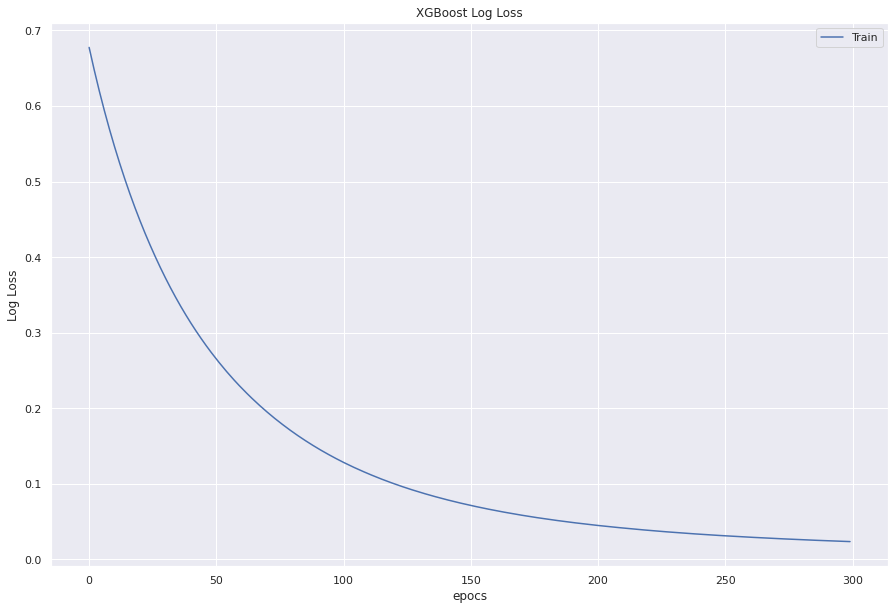

In [131]:
train_loses=np.mean([model.evals_result()['validation_0']['logloss'] for model in all_models],axis=0)
x_axis = range(0, len(train_loses))
# plot log loss
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(x_axis, train_loses, label='Train');
ax.legend();
plt.ylabel('Log Loss');
plt.title('XGBoost Log Loss');
plt.xlabel('epocs');
plt.show();

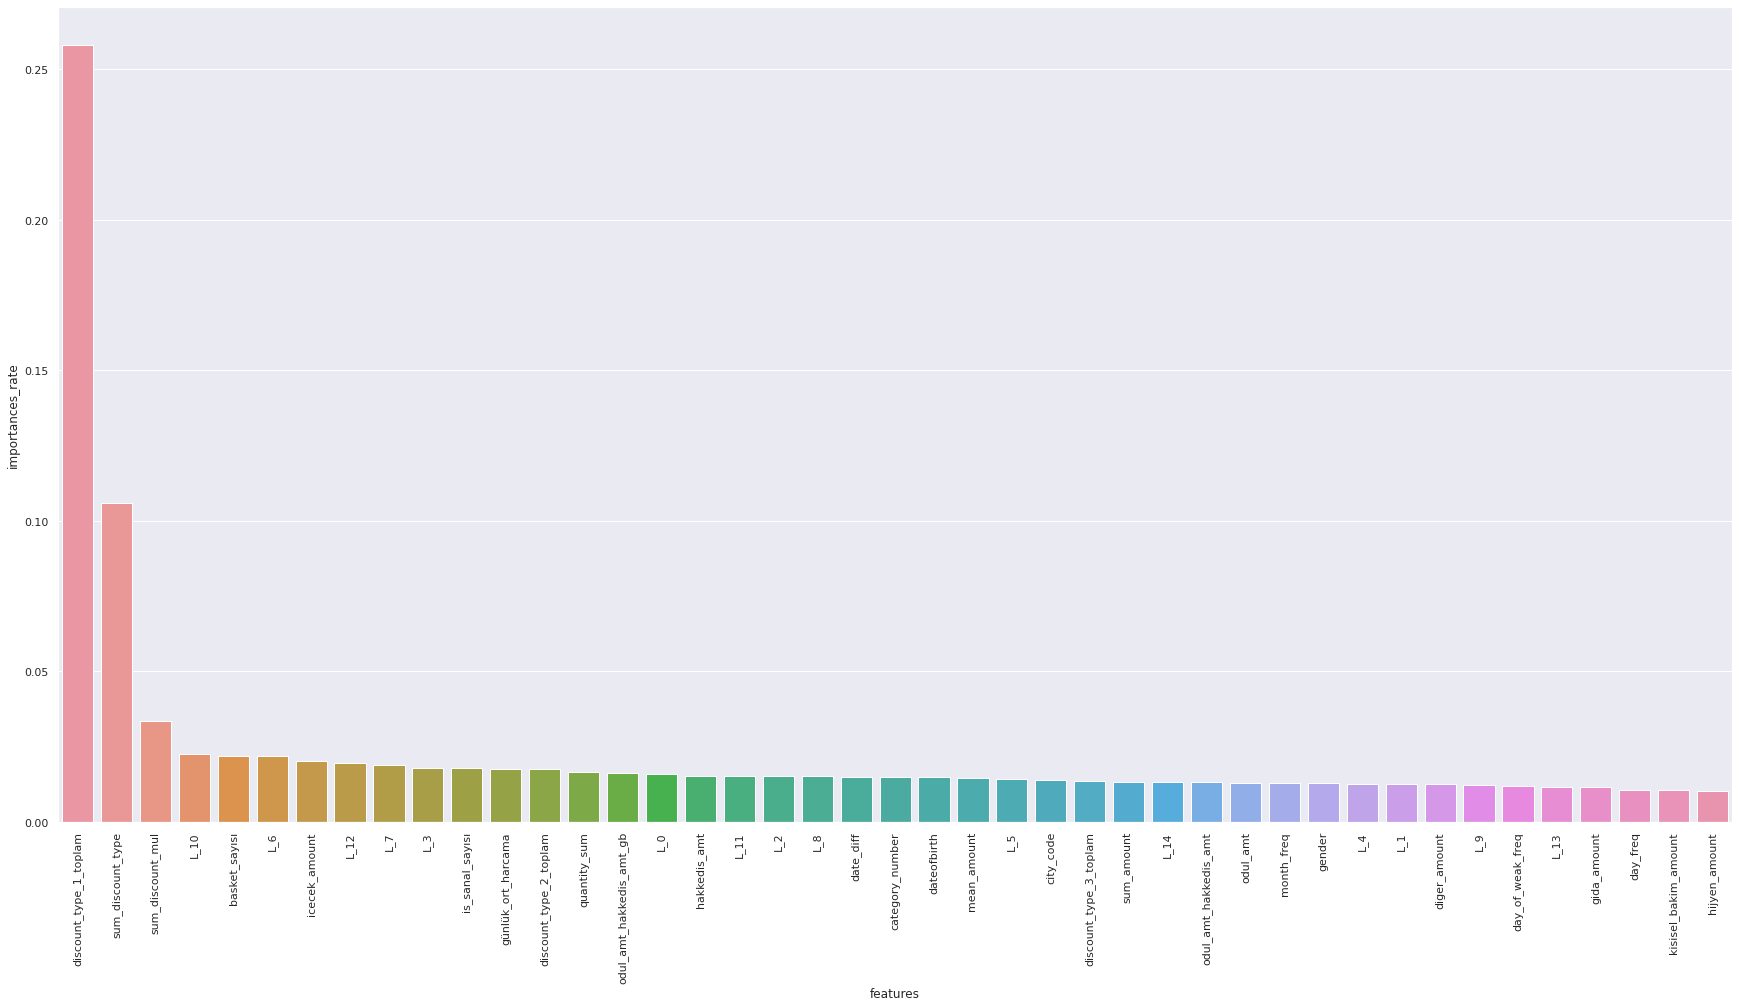

In [132]:
importances=pd.DataFrame([model.feature_importances_ for model in all_models]).mean(axis=0).values
dum=pd.DataFrame(data={'features':data_test.columns,'importances_rate':importances}).sort_values('importances_rate',ascending=False)
sns.set(rc={'figure.figsize':(30,15)})
g=sns.barplot(x=dum.features,y=dum.importances_rate)
g.set_xticklabels(g.get_xticklabels(), rotation=90);


In [134]:
submission=test_id.to_frame()
submission['response']=pred
sample_submission=pd.read_csv('/kaggle/input/migros-datathon-coderspace/sample_submission.csv')
sample_submission=sample_submission[['individualnumber']].merge(submission,how='left',on='individualnumber').fillna(0)
sample_submission.response=sample_submission.response.astype(int)
sample_submission.set_index('individualnumber',drop=True,inplace=True)
sample_submission.to_csv('./migros_59.csv')

In [135]:
sample_submission

,response
individualnumber,
95812936,0
23929570,0
95948115,0
100898513,0
12769156,1
...,...
93418529,0
97397069,0
95212479,0


# Conclusions

I have reached a 0.45 f1 score in the leaderboard on Kaggle. This is not bad, but might be better. Maybe more feature engineering ways make better results.

"İf you want to change the world,you should train a Model :))"